## identify and evaluate clusters

This notebook identifies decision regions based on the identified decision points and trained kernels from historical patients profile. Before running this notebook, make sure you run the `launch_P_calc_four_action.py` file to calculate the P matrix, which determines whether a patient trajectory data point has neighbors around it and can be categorized as a decision point. 

In [1]:
import sys
sys.path.insert(0, "../")

import copy
from collections import defaultdict
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

from src.learn_kernel import LearningKernel
from src.pipeline_mimic import feature_selection, get_train_test_action_pred
from src.cluster_util import (
    load_data,
    load_kernel,
    find_dp,
    select_K,
    cluster,
    sort_by_feat,
)
from src.cluster_viz import *

np.random.seed(888)
torch.manual_seed(888)
import pylab
import matplotlib.patheffects
from matplotlib.lines import Line2D
import matplotlib.patches
import time

params = {
    "legend.fontsize": "xx-large",
    "axes.labelsize": "xx-large",
    "xtick.labelsize": "xx-large",
    "ytick.labelsize": "xx-large",
    "axes.titlesize": "xx-large",
    "figure.titlesize": "xx-large",
    "axes.linewidth": 0.8,
    "lines.linewidth": 3,
    "lines.markersize": 10.0,
}

pylab.rcParams.update(params)
plt.style.use("default")

%reload_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data Loading

In [2]:
data_dir = "PATH/TO/YOUR/DATA"
results_dir = "PATH/TO/YOUR/INTERMEDIATE/RESULTS"

s_path = f"{data_dir}/states_modified_1hr.p"
a_path = f"{data_dir}/actions_discretized_vaso5_fluid4_1hr.p"
r_path = f"{data_dir}rewards_1hr.p"

p_path = f"{results_dir}/P_Results_20211127/P_r=0.9_n=10_multiclass_withinds_norepeat_s1_train.p"
p_path_test = f"{results_dir}/P_Results_20211127/P_r=0.9_n=10_multiclass_withinds_norepeat_s1_test.p"
kernel_path = f"{results_dir}/multi_withindics_interpret_kernel_setseed888"

feat_indices = pickle.load(open(f"{results_dir}/selected_feature_indices.p", "rb"))

version_date = "12012021"

<IPython.core.display.Javascript object>

#### Features clinicians deem important (for visualization purpose, index from modified state file)

- time from ICU admission: index 0
- MAP: index 55
- Bicarbonate or CO2: index 9 or index 49
- fio2: index 15
- Urine: index 39
- Magnesium or PO2: index 25 or index 59
- time from Intubation: 108
- recent treatment fbt: 109
- recent treatment vaso: 110
- recent_treat_response: 111
- hrs_since_recent_treat: 112
- co2_above_30ind: 113
- co2_below_20ind: 114
- map_above_65ind: 115
- fio2_above_21ind: 116

In [3]:
clinician_feats = {
    "Times": 0,
    "map": 55,
    "bicarbonate": 9,
    "fio2": 15,
    "urine": 39,
    "magnesium": 25,
    "hrs_intubed": 108,
    "recent_treat_fbt": 109,
    "recent_treat_vaso": 110,
    "recent_treat_response": 111,
    "hrs_since_recent_treat": 112,
    "co2_above_30ind": 113,
    "co2_below_20ind": 114,
    "map_above_65ind": 115,
    "fio2_above_21ind": 116,
}

<IPython.core.display.Javascript object>

#### Load S1, S2, A, etc.

In [4]:
%%time

# Can change what to return in load_data function
# Manually add MAP feature in the load_data function
S1_train_kernel, S2_train_kernel, S1_train_viz, S2_train_viz, \
A_train, PID_train, column_names, column_names_noind, \
S1_test_kernel, S2_test_kernel, S1_test_viz, S2_test_viz, A_test, PID_test, \
S1_train_map_below65_indices, S1_test_map_below65_indices = \
load_data(s_path, a_path, r_path, 
          feat_indices, clinician_feats, 
          original=True, include_action_states=True, transform=False)

viz_scaler = StandardScaler().fit(S1_train_viz)

CPU times: user 1min 29s, sys: 11.2 s, total: 1min 40s
Wall time: 1min 44s


<IPython.core.display.Javascript object>

In [276]:
S1_train_map_below65_indices.shape, S1_test_map_below65_indices.shape

((102844,), (34549,))

<IPython.core.display.Javascript object>

In [5]:
print(column_names)
print(column_names_noind)

Index(['Times', 'normed_time', 'bicarbonate', 'fio2', 'lactate', 'magnesium',
       'urine', 'co2', 'map', 'sbp', 'GCS', 'fio2_8ind', 'lactate_8ind',
       'magnesium_everind', 'platelets_8ind', 'hgb_8ind', 'po2_8ind',
       'po2_everind', 'hrs_intubed', 'recent_treat_fbt', 'recent_treat_vaso',
       'recent_treat_response', 'hrs_since_recent_treat', 'co2_above_30ind',
       'co2_below_20ind', 'map_above_65ind', 'fio2_above_21ind', 'Fluids',
       'Vasopressors', 'total_all_prev_vasos', 'total_all_prev_fluids',
       'total_last_8hrs_vasos', 'total_last_8hrs_fluids'],
      dtype='object')
['map', 'normed_time', 'bicarbonate', 'fio2', 'lactate', 'magnesium', 'urine', 'co2', 'Times', 'sbp', 'GCS', 'hrs_intubed', 'recent_treat_fbt', 'recent_treat_vaso', 'recent_treat_response', 'hrs_since_recent_treat', 'Fluids', 'Vasopressors', 'total_all_prev_vasos', 'total_all_prev_fluids', 'total_last_8hrs_vasos', 'total_last_8hrs_fluids', 'co2_above_30ind', 'co2_below_20ind', 'map_above_65ind

<IPython.core.display.Javascript object>

#### Load Kernel and P

In [236]:
kernel = load_kernel(kernel_path, 33, 4, 500)
p_matrix = pickle.load(open(p_path, "rb"))[: len(S1_train_map_below65_indices)]
dp_idx = find_dp(p_matrix)
p_matrix_test = pickle.load(open(p_path_test, "rb"))[: len(S1_test_map_below65_indices)]
dp_idx_test = find_dp(p_matrix_test)

<IPython.core.display.Javascript object>

#### Select DP only data

In [7]:
A_dp = A_train[S1_train_map_below65_indices][dp_idx]
P_dp = PID_train[S1_train_map_below65_indices][dp_idx]
S1_kernel_dp = S1_train_kernel[S1_train_map_below65_indices][dp_idx]
S2_kernel_dp = S2_train_kernel[S1_train_map_below65_indices][dp_idx]
S1_viz_dp = S1_train_viz[S1_train_map_below65_indices][dp_idx]
S2_viz_dp = S2_train_viz[S1_train_map_below65_indices][dp_idx]

A_dp_test = A_test[S1_test_map_below65_indices][dp_idx_test]
P_dp_test = PID_test[S1_test_map_below65_indices][dp_idx_test]
S1_kernel_dp_test = S1_test_kernel[S1_test_map_below65_indices][dp_idx_test]
S2_kernel_dp_test = S2_test_kernel[S1_test_map_below65_indices][dp_idx_test]
S1_viz_dp_test = S1_test_viz[S1_test_map_below65_indices][dp_idx_test]
S2_viz_dp_test = S2_test_viz[S1_test_map_below65_indices][dp_idx_test]

<IPython.core.display.Javascript object>

In [121]:
np.save(f"{results_dir}/A_dp_{version_date}.npy", A_dp)
np.save(f"{results_dir}/S1_viz_dp_{version_date}.npy", S1_viz_dp)
np.save(f"{results_dir}/S2_viz_dp_{version_date}.npy", S2_viz_dp)

<IPython.core.display.Javascript object>

#### Transform from S state to Z state

In [8]:
Z1 = kernel.trans_to_rff(S1_kernel_dp)
Z2 = kernel.trans_to_rff(S2_kernel_dp)

<IPython.core.display.Javascript object>

#### Split samples by wheter patients received vaso in past 8hrs

In [9]:
# Train
vaso_idx = column_names_noind.index("total_last_8hrs_vasos")
vaso_8hrs = S1_viz_dp[:, vaso_idx]
vaso_8hrs_Y = np.where(vaso_8hrs > 0)[0]
vaso_8hrs_N = np.where(vaso_8hrs == 0)[0]

print("For Training set:")
print(f"Number of people with vaso in the past 8 hours: {len(vaso_8hrs_Y)}")
print(f"Number of people without vaso in the past 8 hours: {len(vaso_8hrs_N)}")

Z1_vaso = Z1[vaso_8hrs_Y]
Z1_novaso = Z1[vaso_8hrs_N]

S1_vaso = S1_kernel_dp[vaso_8hrs_Y]
S1_novaso = S1_kernel_dp[vaso_8hrs_N]
S1_vaso_viz = S1_viz_dp[vaso_8hrs_Y]
S1_novaso_viz = S1_viz_dp[vaso_8hrs_N]

A_vaso_viz = A_dp[vaso_8hrs_Y]
A_novaso_viz = A_dp[vaso_8hrs_N]

# Test
vaso_8hrs_test = S1_viz_dp_test[:, vaso_idx]
vaso_8hrs_Y_test = np.where(vaso_8hrs_test > 0)[0]
vaso_8hrs_N_test = np.where(vaso_8hrs_test == 0)[0]
S1_vaso_test = S1_kernel_dp_test[vaso_8hrs_Y_test]
S1_novaso_test = S1_kernel_dp_test[vaso_8hrs_N_test]
S1_vaso_viz_test = S1_viz_dp_test[vaso_8hrs_Y_test]
S1_novaso_viz_test = S1_viz_dp_test[vaso_8hrs_N_test]

print("For Test set:")
print(f"Number of people with vaso in the past 8 hours: {len(vaso_8hrs_Y_test)}")
print(f"Number of people without vaso in the past 8 hours: {len(vaso_8hrs_N_test)}")

For Training set:
Number of people with vaso in the past 8 hours: 11379
Number of people without vaso in the past 8 hours: 27796
For Test set:
Number of people with vaso in the past 8 hours: 4168
Number of people without vaso in the past 8 hours: 9267


<IPython.core.display.Javascript object>

Number of patients with no vaso in past 8 hours is almost 10 times as many as those received vaso.

## Hierarchical Clustering

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

def train_knn(X_train, y_train, model_path):
    """Create and fit a nearest-neighbor classifier"""
    from sklearn.neighbors import KNeighborsClassifier
    from joblib import dump, load

    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    dump(knn, model_path)
    return knn


def summarize_actions(curr_actions):
    """
    Summarize the actions taken during a temporal clump into:
    nothing, fluid at some point, vaso at some point, both fluid and vaso in the range [0, 3].
    """

    some_fluid = (curr_actions % 4 > 0) > 0
    some_vaso = (curr_actions // 4 > 0) > 0

    return some_fluid + 2 * some_vaso


def cluster_feat_mean(S, A, Z):
    """
    Calculate the mean of each feature for intermediate clusters for each action taken

    Argument:
    S: S states(features) of points
    A: Binned actions of points
    Z: Linkage output from scipy
    """
    clusters = {}
    children = {}
    parents = {}
    n = len(S)
    for i, merge in enumerate(Z):
        clusters[i + n] = {}

        a, b = merge[0], merge[1]
        # the clusters are 1-indexed by scipy
        children[n + i] = [a, b]
        parents[(a, b)] = n + i

        # both clusters are original points
        if merge[0] <= len(Z) and merge[1] <= len(Z):
            clusters[i + n]["idx"] = np.array([int(merge[0]), int(merge[1])])
            # read from S and A
            c1_s, c1_a = S[int(merge[0])], A[int(merge[0])]
            c2_s, c2_a = S[int(merge[1])], A[int(merge[1])]
            if c1_a == c2_a:
                clusters[i + n][c1_a] = [
                    (c1_s + c2_s) / 2,
                    2,
                ]  # feature mean from two points
            else:
                clusters[i + n][c1_a] = [c1_s, 1]
                clusters[i + n][c2_a] = [c2_s, 1]

        # both clusters are not original points
        elif merge[0] > len(Z) and merge[1] > len(Z):
            c1 = int(merge[0])
            c2 = int(merge[1])
            clusters[i + n]["idx"] = np.concatenate(
                (clusters[c1]["idx"], clusters[c2]["idx"])
            )
            for a in range(4):
                # if both actions exist, calculate new mean
                if a in clusters[c1] and a in clusters[c2]:
                    clusters[i + n][a] = [
                        (
                            clusters[c1][a][0] * clusters[c1][a][1]
                            + clusters[c2][a][0] * clusters[c2][a][1]
                        )
                        / (clusters[c1][a][1] + clusters[c2][a][1]),
                        (clusters[c1][a][1] + clusters[c2][a][1]),
                    ]
                # skip if action is not in either cluster
                elif a not in clusters[c1] and a not in clusters[c2]:
                    continue
                else:
                    c = c1 if a in clusters[c1] else c2
                    clusters[i + n][a] = [clusters[c][a][0], clusters[c][a][1]]

        # one cluster is original point one is not
        else:
            # set c1 to be original point and c2 to be clusters
            (c1, c2) = (
                (int(merge[0]), int(merge[1]))
                if merge[0] <= len(Z)
                else (int(merge[1]), int(merge[0]))
            )

            c1_a = A[c1]
            clusters[i + n] = copy.deepcopy(clusters[c2])
            clusters[i + n]["idx"] = np.concatenate(
                (np.array([c1]), clusters[c2]["idx"])
            )
            if c1_a in clusters[c2]:
                clusters[i + n][c1_a] = [
                    (clusters[i + n][c1_a][0] * clusters[i + n][c1_a][1] + S[c1])
                    / (clusters[i + n][c1_a][1] + 1),
                    clusters[i + n][c1_a][1] + 1,
                ]
            else:
                clusters[i + n][c1_a] = [S[c1], 1]
    return clusters, children, parents

def split(Z, clusters, children, parents, A, S, thresh, feat_names, max_cluster_num=15):
    """
    Decide when to stop splitting when Z and clusters are fed
    Split Condition: When feature means are too different for
    """
    cursor = len(Z) - 1
    final_cluster = set()
    skip_cluster = (
        set()
    )  # If not spliting on parent, all child clusters will be skipped
    final_cluster_idx = []
    split_count = 0
    diff_tracker = []
    split_category = []

    while cursor > 0 and len(final_cluster) < max_cluster_num:
        c1, c2 = int(Z[cursor][0]), int(Z[cursor][1])
        split = False
        cursor -= 1

        # Skip on rows where parents won't be split
        if c1 in skip_cluster or c2 in skip_cluster:
            continue
        if c1 <= len(Z) and c2 <= len(Z):
            continue
        elif c1 <= len(Z) and c2 > len(Z):
            c1_feat = S[c1]
            c1_a = A[c1]
            c2_feat = clusters[c2]
            if c1_a in c2_feat:
                # print(abs(c1_feat - c2_feat[c1_a][0]))
                if (abs(c1_feat - c2_feat[c1_a][0]) > thresh).any():
                    split = True
                    diff_tracker.append(abs(c1_feat - c2_feat[c1_a][0]))
                    split_category.append(1)
        elif c1 > len(Z) and c2 <= len(Z):
            c2_feat = S[c2]
            c2_a = A[c2]
            c1_feat = clusters[c1]
            if c2_a in c1_feat:
                # print(abs(c2_feat - c1_feat[c2_a][0]))
                if (abs(c2_feat - c1_feat[c2_a][0]) > thresh).any():
                    split = True
                    diff_tracker.append(abs(c2_feat - c1_feat[c2_a][0]))
                    split_category.append(1)
        else:
            c1_feat, c2_feat = clusters[c1], clusters[c2]
            for a in range(4):
                # Only compare actions that exist in both clusters
                if a in c1_feat and a in c2_feat:
                    if (abs(c2_feat[a][0] - c1_feat[a][0]) > thresh).any():
                        split = True
                        diff_tracker.append(abs(c2_feat[a][0] - c1_feat[a][0]))
                        split_category.append(2)
        if split == True:
            split_count += 1
            # Remove parent node
            parent = parents[(c1, c2)]
            if parent in final_cluster:
                final_cluster.remove(parent)
            final_cluster.add(c1)
            final_cluster.add(c2)
        else:
            # if not further split, append the list of index to group
            parent_num = parents[(c1, c2)]
            final_cluster.add(parent_num)
            if c1 in final_cluster:
                final_cluster.remove(c1)
            if c2 in final_cluster:
                final_cluster.remove(c2)
            queue = [c1, c2]
            while queue:
                c_num = queue.pop(0)
                skip_cluster.add(c_num)
                if c_num in children:
                    c1, c2 = children[c_num][0], children[c_num][1]
                    queue.append(children[c_num][0])
                    queue.append(children[c_num][1])
    for c_num in final_cluster:
        if c_num > len(Z):
            final_cluster_idx.append(clusters[c_num]["idx"])
    return final_cluster_idx, split_count, diff_tracker, split_category

def fancy_dendrogram(*args, **kwargs):
    """draw dendrogram for the hierarchical clustering"""
    max_d = kwargs.pop("max_d", None)
    if max_d and "color_threshold" not in kwargs:
        kwargs["color_threshold"] = max_d
    annotate_above = kwargs.pop("annotate_above", 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get("no_plot", False):
        plt.title("Hierarchical Clustering Dendrogram (truncated)")
        plt.xlabel("sample index or (cluster size)")
        plt.ylabel("distance")
        for i, d, c in zip(ddata["icoord"], ddata["dcoord"], ddata["color_list"]):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, "o", c=c)
                plt.annotate(
                    "%.3g" % y,
                    (x, y),
                    xytext=(0, -5),
                    textcoords="offset points",
                    va="top",
                    ha="center",
                )
        if max_d:
            plt.axhline(y=max_d, c="k")
    return ddata

<IPython.core.display.Javascript object>

#### Clustering for patients received vasopressor in last 8 hrs

In [14]:
%%time

# Remove time into ICU from feature
S1_vaso_viz_normed = viz_scaler.transform(S1_vaso_viz)
time_indices = [1, 8]
S1_vaso_viz_notime = np.delete(S1_vaso_viz_normed, time_indices, 1)
Z = linkage(S1_vaso_viz_notime, method='complete', metric='euclidean')

CPU times: user 4.72 s, sys: 387 ms, total: 5.11 s
Wall time: 5.18 s


<IPython.core.display.Javascript object>

In [367]:
%%time

# Check Cophenetic Correlation Coefficient
# Measures how well the hierarchical cluster maintains actual pairwise distances of raw data
# The closer is the value to 1, the more preserved is original distance
c, coph_dists = cophenet(Z, pdist(S1_vaso_viz_notime, metric="euclidean"))
print(c)

0.8549552242062181
CPU times: user 2.61 s, sys: 1.13 s, total: 3.74 s
Wall time: 3.79 s


<IPython.core.display.Javascript object>

In [15]:
%%time 

feat_name_no_time = [feat for feat in column_names_noind if feat not in ['normed_time', 'Times']]

A_vaso_binned = summarize_actions(A_vaso_viz)
clusters, children, parents = cluster_feat_mean(
    S1_vaso_viz_notime, A_vaso_binned, Z
)

CPU times: user 252 ms, sys: 5.54 ms, total: 257 ms
Wall time: 260 ms


<IPython.core.display.Javascript object>

In [16]:
final_cluster, sc, diff_tracker, split_category = split(
    Z,
    clusters,
    children,
    parents,
    A_vaso_binned,
    S1_vaso_viz_notime,
    [1] * len(feat_name_no_time),
    feat_name_no_time,
    max_cluster_num=20,
)

<IPython.core.display.Javascript object>

In [17]:
vaso_cluster = np.zeros(len(S1_vaso_viz_notime), dtype="int")
for i, indices in enumerate(final_cluster):
    for idx in indices:
        vaso_cluster[idx] = int(i + 1)

<IPython.core.display.Javascript object>

In [18]:
print(np.bincount(vaso_cluster))
print("\n")
print(
    f"Number of cluster with more than 20 points - {(np.bincount(vaso_cluster)>10).sum()}"
)

[   1    6   59 9633   32  499  141  680    3   96   88    2    2    4
    4    8   17    5   27   72]


Number of cluster with more than 20 points - 11


<IPython.core.display.Javascript object>

**Save KNN clustering model for people with vasopressor in past 8 hours**

In [19]:
vaso_knn = train_knn(
    S1_vaso_viz_notime,
    vaso_cluster,
    f"{results_dir}/model/vaso_knn_{version_date}.joblid",
)

<IPython.core.display.Javascript object>

**Cluster points in test set for people with vasopressor in past 8 hours**

In [20]:
S1_vaso_viz_normed_test = viz_scaler.transform(S1_vaso_viz_test)
S1_vaso_viz_notime_test = np.delete(S1_vaso_viz_normed_test, time_indices, 1)
vaso_cluster_test = vaso_knn.predict(S1_vaso_viz_notime_test)
print(np.bincount(vaso_cluster_test))
print("\n")
print(
    f"Number of cluster with more than 20 points - {(np.bincount(vaso_cluster_test)>10).sum()}"
)

[   0    2   25 3578    3  173   36  244    0   22   54    0    0    0
    0    1    4    0    9   17]


Number of cluster with more than 20 points - 8


<IPython.core.display.Javascript object>

#### Clustering for patients who didn't receive vasopressor in last 8 hrs

In [21]:
S1_novaso_viz_normed = viz_scaler.transform(S1_novaso_viz)
S1_novaso_viz_notime = np.delete(S1_novaso_viz_normed, time_indices, 1)
Z_novaso = linkage(S1_novaso_viz_notime, method="complete", metric="euclidean")
A_novaso_binned = summarize_actions(A_novaso_viz)

<IPython.core.display.Javascript object>

In [403]:
c, coph_dists = cophenet(Z_novaso, pdist(S1_novaso_viz_notime, metric="euclidean"))
print(c)

0.6999955947636582


<IPython.core.display.Javascript object>

In [22]:
%%time 

novaso_clusters, novaso_children, novaso_parents = cluster_feat_mean(
    S1_novaso_viz_notime, A_novaso_binned, Z_novaso
)

CPU times: user 646 ms, sys: 48.2 ms, total: 695 ms
Wall time: 697 ms


<IPython.core.display.Javascript object>

In [23]:
sample_final_cluster, sample_sc, sample_diff_tracker, sample_split_category = split(
    Z_novaso,
    novaso_clusters,
    novaso_children,
    novaso_parents,
    A_novaso_binned,
    S1_novaso_viz_notime,
    [1] * len(feat_name_no_time),
    feat_name_no_time,
    max_cluster_num=20,
)

<IPython.core.display.Javascript object>

In [24]:
novaso_cluster = np.zeros(len(S1_novaso_viz_normed), dtype="int")
for i, indices in enumerate(sample_final_cluster):
    for idx in indices:
        novaso_cluster[idx] = int(i + 1)

<IPython.core.display.Javascript object>

In [25]:
print(np.bincount(novaso_cluster))
print("\n")
print(
    f"Number of cluster with more than 20 points - {(np.bincount(novaso_cluster)>20).sum()}"
)

[    2     6     5     5   401    11  2430   458    87  2473 21617     8
     5     2   134   102    12     2    36]


Number of cluster with more than 20 points - 9


<IPython.core.display.Javascript object>

**Save KNN clustering model for people without vasopressor in past 8 hours**

In [34]:
novaso_knn = train_knn(
    S1_novaso_viz_notime,
    novaso_cluster,
    f"{results_dir}/model/novaso_knn_{version_date}.joblid",
)

<IPython.core.display.Javascript object>

**Cluster points in test set for people without vasopressor in past 8 hours**

In [35]:
S1_novaso_viz_normed_test = viz_scaler.transform(S1_novaso_viz_test)
S1_novaso_viz_notime_test = np.delete(S1_novaso_viz_normed_test, time_indices, 1)
novaso_cluster_test = novaso_knn.predict(S1_novaso_viz_notime_test)
print(np.bincount(novaso_cluster_test))
print("\n")
print(
    f"Number of cluster with more than 20 points - {(np.bincount(novaso_cluster_test)>10).sum()}"
)

[   0    4    0    1  173    2  737  195    1  780 7227    6    0    0
   86   33    0    0   22]


Number of cluster with more than 20 points - 8


<IPython.core.display.Javascript object>

#### Reorder clusters

In [36]:
offset = {k: v for v, k in enumerate(np.unique(novaso_cluster))}
novaso_cluster_clean = np.array([offset[x] for x in novaso_cluster])

<IPython.core.display.Javascript object>

In [37]:
Z1_novaso_labels = novaso_cluster_clean
Z1_vaso_labels = vaso_cluster

<IPython.core.display.Javascript object>

In [38]:
novaso_cluster_clean_test = np.array([offset[x] for x in novaso_cluster_test])
Z1_novaso_labels_test = novaso_cluster_clean_test
Z1_vaso_labels_test = vaso_cluster_test

<IPython.core.display.Javascript object>

#### Sort groups by descending order by feature (MAP)

In [39]:
map_idx = 0

S1_viz_by_label, S1_labels_ordered, idx_map = sort_by_feat(
    map_idx,
    Z1_novaso_labels,
    Z1_vaso_labels,
    S1_novaso_viz,
    S1_vaso_viz,
    vaso_8hrs_N,
    vaso_8hrs_Y,
)

<IPython.core.display.Javascript object>

In [122]:
# Save ordered labels
np.save(
    f"{results_dir}/S1_dp_ordered_label_hierarchy_customsplit_{version_date}.npy",
    S1_labels_ordered,
)

# Load ordered labels
# S1_labels_ordered = np.load("../../Data/S1_dp_ordered_label_hierarchy_customsplit.npy")

<IPython.core.display.Javascript object>

In [123]:
included_clusters

array([ 7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 27, 29,
       32, 34])

<IPython.core.display.Javascript object>

**Map test data to train data cluster order**

In [41]:
S1_labels_ordered_test = np.zeros(len(Z1_novaso_labels_test) + len(Z1_vaso_labels_test))

for idx, c in zip(vaso_8hrs_N_test, Z1_novaso_labels_test):
    S1_labels_ordered_test[idx] = int(idx_map[c])

for idx, c in zip(vaso_8hrs_Y_test, Z1_vaso_labels_test):
    S1_labels_ordered_test[idx] = int(idx_map[c])

S1_labels_ordered_test = S1_labels_ordered_test.astype(int)

# np.save(
#     "../../Data/S1_dp_ordered_label_hierarchy_customsplit_test.npy",
#     S1_labels_ordered_test,
# )

<IPython.core.display.Javascript object>

#### Configure code running - training vs testing

In [42]:
test = False  # Toggle if we are doing training vs testing
k = len(np.unique(S1_labels_ordered))

if test:
    P_dp = P_dp_test
    A_dp = A_dp_test
    S1_labels_ordered = S1_labels_ordered_test

<IPython.core.display.Javascript object>

#### Get mortality info

In [43]:
def find_patient_sequence(P_dp):
    """
    Find the end index for each patient sequence

    Arguments:
    P_dp : array of dps with patient id

    Returns:
    unique_pids : list of unique pids corresponding to the sequence
    patient_starts : list of starting index for the patient
    patient_ends : list of ending index for the patient
    """
    patient_starts = []
    unique_pids = []
    prev_pid = 0

    for i, curr_pid in enumerate(P_dp):
        if curr_pid != prev_pid:
            patient_starts.append(i)
            unique_pids.append(curr_pid)
        prev_pid = curr_pid

    patient_ends = [s for s in patient_starts[1:]]
    patient_ends.append(len(P_dp))

    return unique_pids, patient_starts, patient_ends


def identify_patients_condition(
    mortality_pkl_path,
    patient_ids,
    patient_starts,
    patient_ends,
    S1_labels_ordered,
    A_dp,
):
    """
    Convert patient info into list of lists
    """

    patient_clusters = dict()
    patient_actions = dict()
    patient_mortality = dict()

    with open(mortality_pkl_path, "rb") as file:
        pid_mort_dict = pickle.load(file)

    for i, pid in enumerate(patient_ids):
        ps = patient_starts[i]
        pe = patient_ends[i]
        patient_clusters[pid] = S1_labels_ordered[ps:pe]  # only include DP labels
        patient_actions[pid] = A_dp[ps:pe]
        patient_mortality[pid] = int(pid_mort_dict[pid]["dead_in_HOSP"])

        deathtime = pid_mort_dict[pid]["dur_from_admi_to_hosp_death"]

        if not np.isnan(deathtime) and deathtime / 3600 / 24 < 30:  # 30-day mort
            patient_mortality[pid] = 1
        else:
            patient_mortality[pid] = 0

    return patient_clusters, patient_actions, patient_mortality


def mortality_transitions(
    patient_clusters, patient_actions, patient_mortality, k, mode="last"
):
    """
    Possible modes: first, last, all.
    """
    from MIMIC.MIMIC_dp_eda.mdp_construction import compress

    assert mode in ["first", "last", "all"]

    mort_pos = np.zeros((k, 4))
    mort_neg = np.zeros((k, 4))

    compressed_trajectories = dict()
    for pid in patient_clusters.keys():
        c = patient_clusters[pid]
        a = patient_actions[pid]
        compressed_trajectories[pid] = compress(c, a)

    # convert compressed trajectories to mort-counting matrices
    for pid, (cvec, avec) in compressed_trajectories.items():
        mort = patient_mortality[pid]
        if len(cvec) > 0:
            if mode == "last":
                cvec, avec = np.flip(cvec), np.flip(avec)

            seen_clusters = set()
            for i in range(len(cvec)):
                if mode == "all" or cvec[i] not in seen_clusters:
                    if mort:
                        mort_pos[cvec[i], avec[i]] += 1
                    else:
                        mort_neg[cvec[i], avec[i]] += 1
                    seen_clusters.add(cvec[i])

    return mort_pos, mort_neg


def test_count_transitions(
    patient_clusters, patient_actions, patient_mortality, k, test=False
):
    """
    Converts trajectories from original states to compressed space.
    Calculates T(), TODO: R.
    Input: labels of [s1] for each pid, actions for each pid, dict of mortality => 0, 1,
    # clusters k.
    """
    from mdp_construction import compress

    # separate clusters into patient trajectories and compress
    compressed_trajectories = dict()
    for pid in patient_clusters.keys():
        c = patient_clusters[pid]  # contains only s1
        a = patient_actions[pid]
        compressed_trajectories[pid] = compress(c, a)

    if test:
        return None, compressed_trajectories

    # convert compressed trajectories to transition matrix
    T_mat = np.zeros((k + 2, 4, k + 2))  # leave space for mortality clusters
    for pid, (cvec, avec) in compressed_trajectories.items():
        if len(cvec) > 0:
            for i in range(len(cvec) - 1):  # transitions within the trajectory
                T_mat[cvec[i], avec[i], cvec[i + 1]] += 1
            # transition to mortality state from last clump
            T_mat[cvec[-1], avec[-1], k + patient_mortality[pid]] += 1

    row_sums = T_mat.sum(axis=2, keepdims=True)
    return (
        np.divide(T_mat, row_sums, out=np.zeros_like(T_mat), where=(row_sums > 0)),
        compressed_trajectories,
    )


def transition_proba_s_a(patient_clusters, patient_actions, cluster_num, action_num=4):
    # Convert the T(s,a,s') matrix to T(s, a) for each cluster
    from mdp_construction import compress

    TSA = np.zeros((cluster_num, action_num))
    compressed_trajectories = dict()
    for pid in patient_clusters.keys():
        c = patient_clusters[pid]  # contains only s1
        a = patient_actions[pid]
        compressed_trajectories[pid] = compress(c, a)
    for pid in compressed_trajectories.keys():
        for c, a in zip(
            compressed_trajectories[pid][0], compressed_trajectories[pid][1]
        ):
            TSA[c][a] += 1
    row_sums = TSA.sum(axis=1)
    # include rows where number of points are more than
    included_clusters = np.where(row_sums >= 10)[0]
    TSA_norm = TSA / row_sums[:, np.newaxis]
    return TSA_norm, TSA, included_clusters

<IPython.core.display.Javascript object>

**Get mortality matrix and transition matrix from train set**

In [65]:
k = len(np.unique(S1_labels_ordered))
unique_pids, patient_starts, patient_ends = find_patient_sequence(P_dp)
patient_clusters, patient_actions, patient_mortality = identify_patients_condition(
    "../../Data/pid_mortality",
    unique_pids,
    patient_starts,
    patient_ends,
    S1_labels_ordered,
    A_dp,
)
mortpos_last, mortneg_last = mortality_transitions(
    patient_clusters, patient_actions, patient_mortality, k, mode="last"
)
mortchance_last = mortpos_last / (mortpos_last + mortneg_last)
mortchance_last = np.nan_to_num(mortchance_last, nan=1)  # assign 1 to nan

tmat, compressed_trajs = test_count_transitions(
    patient_clusters, patient_actions, patient_mortality, k, test=test
)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>

**Get Transition Matrix and determine which clusters should be included**

In [45]:
TSA_normalized, TSA, included_clusters = transition_proba_s_a(
    patient_clusters, patient_actions, cluster_num=k
)

print(len(included_clusters))
included_clusters

19


array([ 7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 27, 29,
       32, 34])

<IPython.core.display.Javascript object>

#### Select clusters with reasonable mortality and different actions

In [46]:
high_mort = np.where(
    np.sum((0.1 <= mortchance_last) & (mortchance_last < 1), axis=1) >= 2
)[0]
more_than_10 = np.where(np.sum((TSA >= 10) & (TSA_normalized > 0.1), axis=1) >= 2)[0]
viz_include_clusters = more_than_10[np.in1d(more_than_10, high_mort)]

<IPython.core.display.Javascript object>

In [47]:
print(len(viz_include_clusters))
viz_include_clusters

9


array([ 8,  9, 11, 12, 15, 18, 20, 24, 34])

<IPython.core.display.Javascript object>

## Visualizations of plots

#### Visualize Clusters

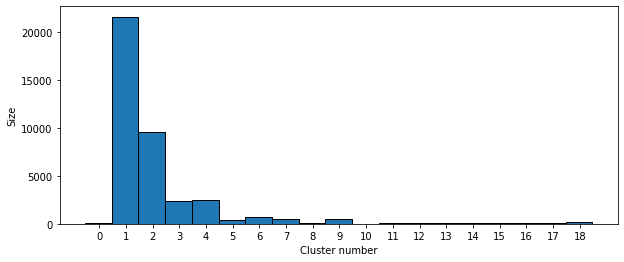

<IPython.core.display.Javascript object>

In [48]:
draw_bar_plot(S1_labels_ordered, included_clusters, f"bar_{version_date}_kernel")

/Users/yuanhengwang/Desktop/Research/Batch-Reinforcement-Learning/MIMIC/MIMIC_dp_eda/cluster_viz.py:54: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0, np.percentile(S_orig[:, i], 95))


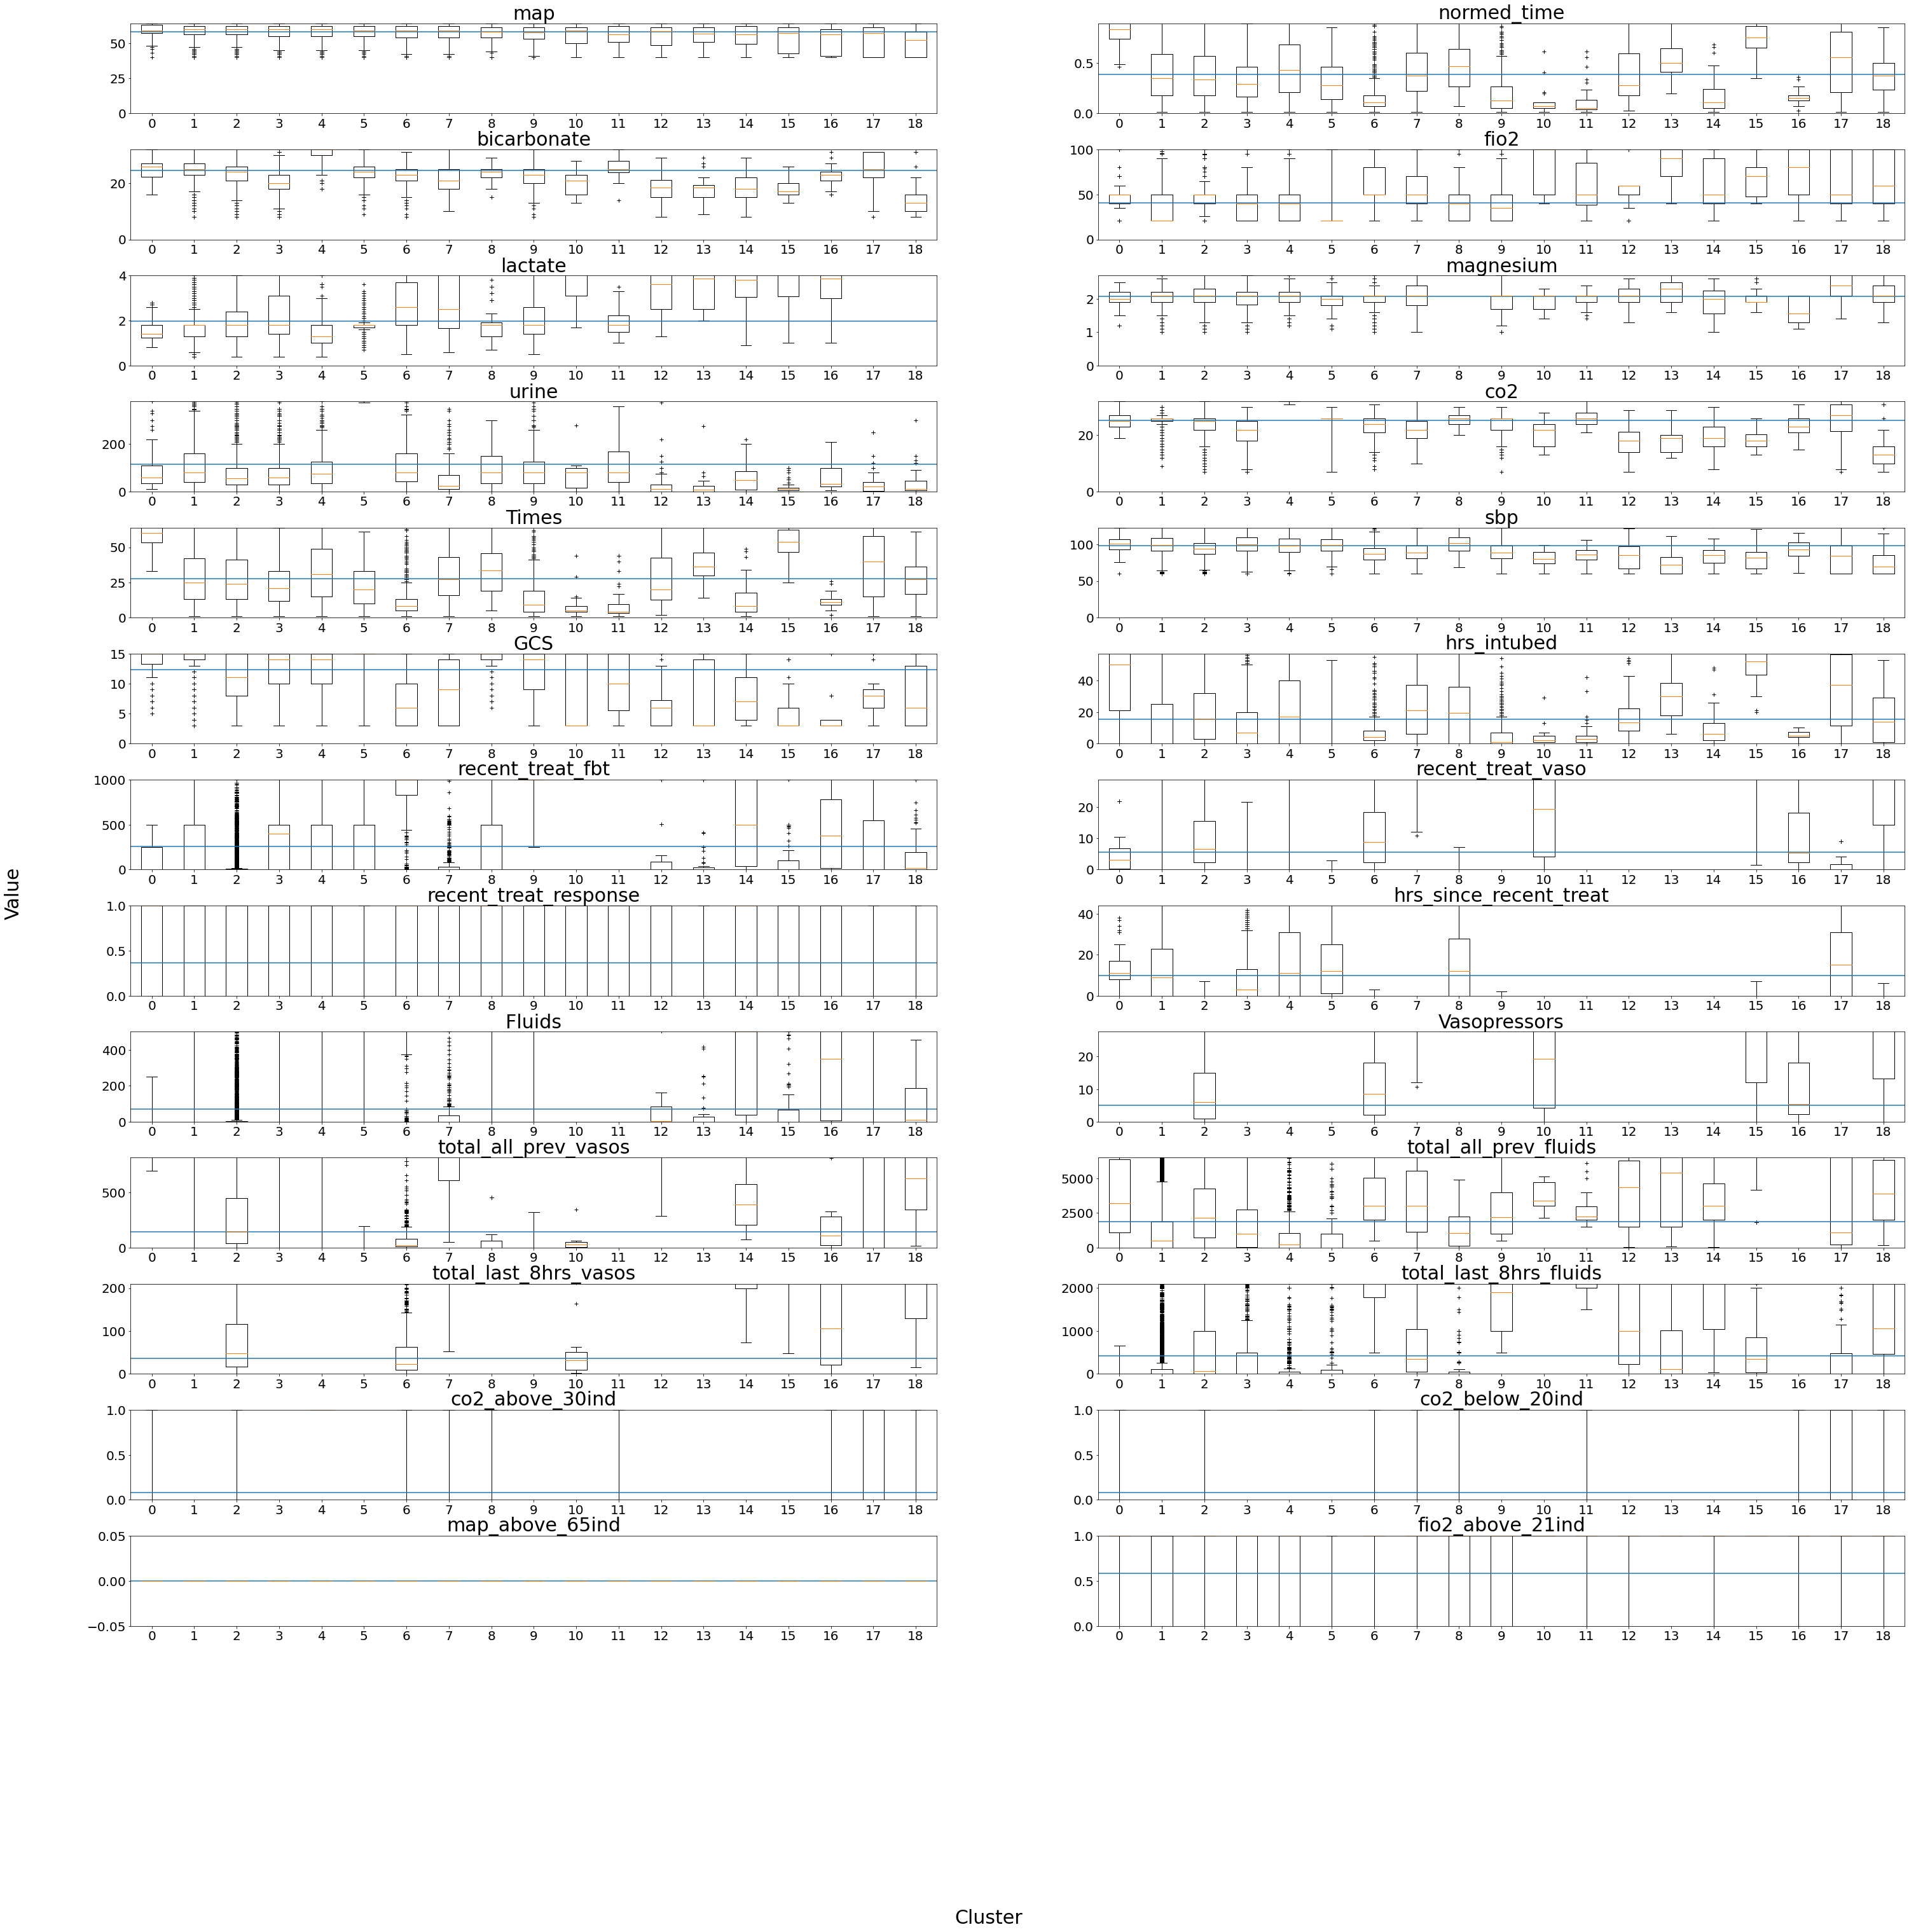

<IPython.core.display.Javascript object>

In [49]:
draw_box_plot(
    column_names_noind,
    S1_viz_by_label,
    S1_viz_dp,
    included_clusters,
    f"box_{version_date}",
)

#### Get Mean Feature Colormaps

In [286]:
column_names_noind

['map',
 'normed_time',
 'bicarbonate',
 'fio2',
 'lactate',
 'magnesium',
 'urine',
 'co2',
 'Times',
 'sbp',
 'GCS',
 'hrs_intubed',
 'recent_treat_fbt',
 'recent_treat_vaso',
 'recent_treat_response',
 'hrs_since_recent_treat',
 'Fluids',
 'Vasopressors',
 'total_all_prev_vasos',
 'total_all_prev_fluids',
 'total_last_8hrs_vasos',
 'total_last_8hrs_fluids',
 'co2_above_30ind',
 'co2_below_20ind',
 'map_above_65ind',
 'fio2_above_21ind']

<IPython.core.display.Javascript object>

In [287]:
column_names_full = [
    "Mean Arterial Pressure (mmHg)",
    "Bicarbonate (mEq/L)",
    "Fio2",
    "Lactate (mg/dL)",
    "Magnesium (mg/dL)",
    "Urine Volume (mL)",
    "Carbon Dioxide (mEq/L)",
    "Hours into ICU",
    "Systolic Blood Pressure (mmHg)",
    "Glasgow Coma Score",
    "Hours Intubated",
    "Most Recent Fluid Dosage (mL)",
    "Most Recent Vasopressor Dosage (mcg/kg/min)",
    "Whether MAP Increased from Recent Treatment",
    "Hours Since Most Recent Treatment",
    "Fluid Dosage in last hour",
    "Vasopressor Dosage in last hour",
    "Total Previous Vasopressor Dosage",
    "Total Previous Fluids Dosage",
    "Vasopressor Dosage in Past 8 Hours",
    "Fluids Dosage in Past 8 Hours ",
]

viz_exclusion_col = [1]

S1_viz_by_label_exclude_column = [
    np.delete(arr, viz_exclusion_col, 1) for arr in S1_viz_by_label
]

<IPython.core.display.Javascript object>

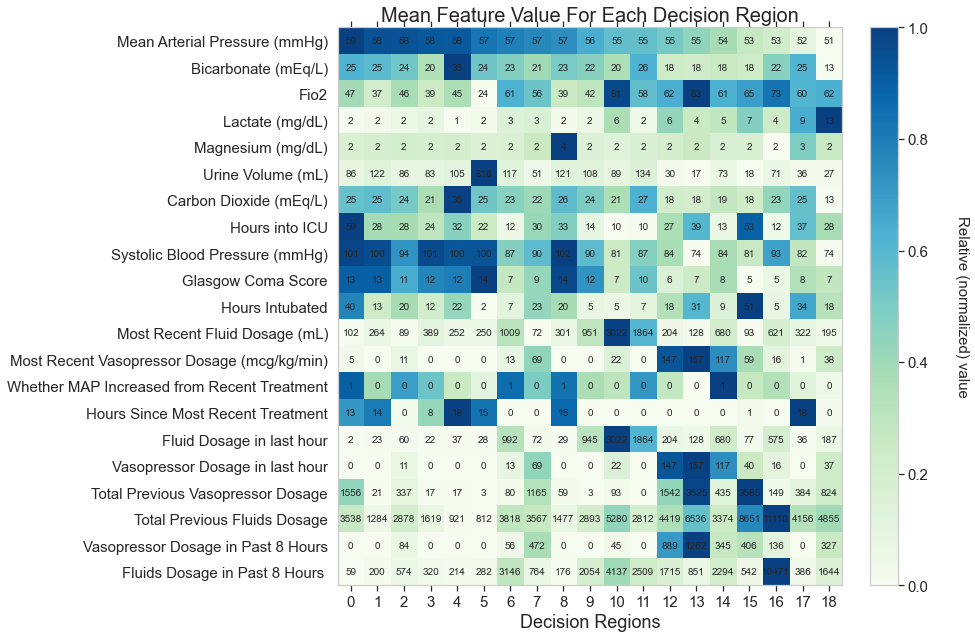

<IPython.core.display.Javascript object>

In [290]:
draw_colormap(
    column_names_full,
    S1_viz_by_label_exclude_column,
    included_clusters,
    f"../results/visualization/colormap_npj_{version_date}",
    width=10,
    height=25,
)

#### Examine Seperation Quality

In [55]:
def eval_split(dc_num, s1_ori_dc, a_dc):
    """
    Evaluate the split of decision clusters formed by kernel.
    For patients inside decision cluster who took different treatments,
    how seperated are their features

    We want to see their features are super close to each other

    Input:
    dc_num : decision cluster index
    s1_dc : s1 states for specified decision cluster
    a_dc : actions for specified decision cluster

    Output:
    Visualization for each feature by group
    """
    import seaborn as sns

    sns.set(style="whitegrid")

    fig, _ = plt.subplots(figsize=(30, 10), sharex=True, sharey=True)
    fig.text(0.5, 0.93, f"Cluster {dc_num + 1}", ha="center", fontsize=20)
    fig.text(0.5, 0.05, "Actions", ha="center", fontsize=20)
    fig.text(0.07, 0.5, "Feature Value", va="center", rotation="vertical", fontsize=20)

    for f in range(s1_ori_dc.shape[1]):
        plt.subplot(3, 10, f + 1)
        sns.violinplot(x=a_dc, y=s1_ori_dc[:, f])
        plt.title(f"{column_names_noind[f]}", fontsize=15)

<IPython.core.display.Javascript object>

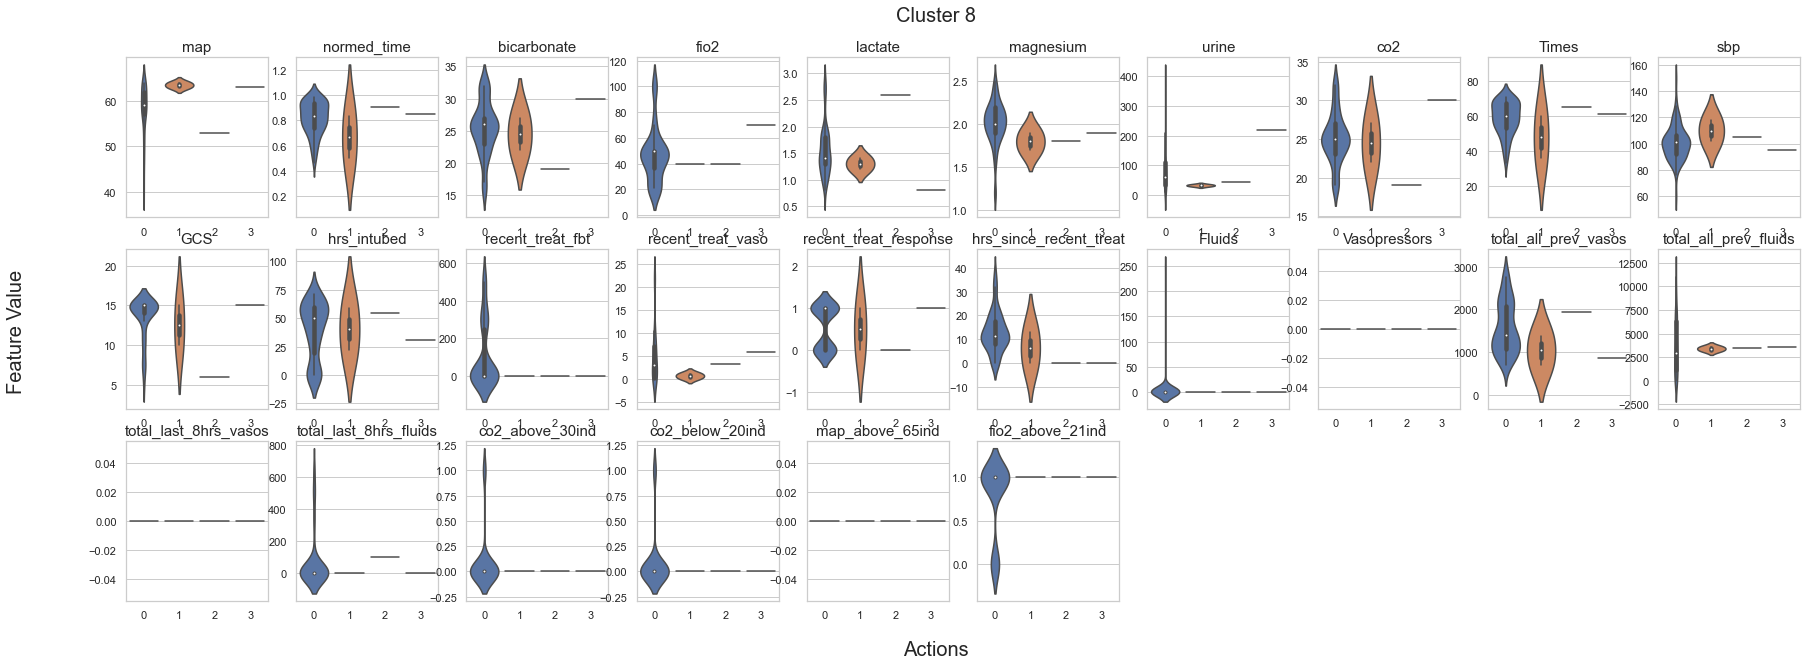

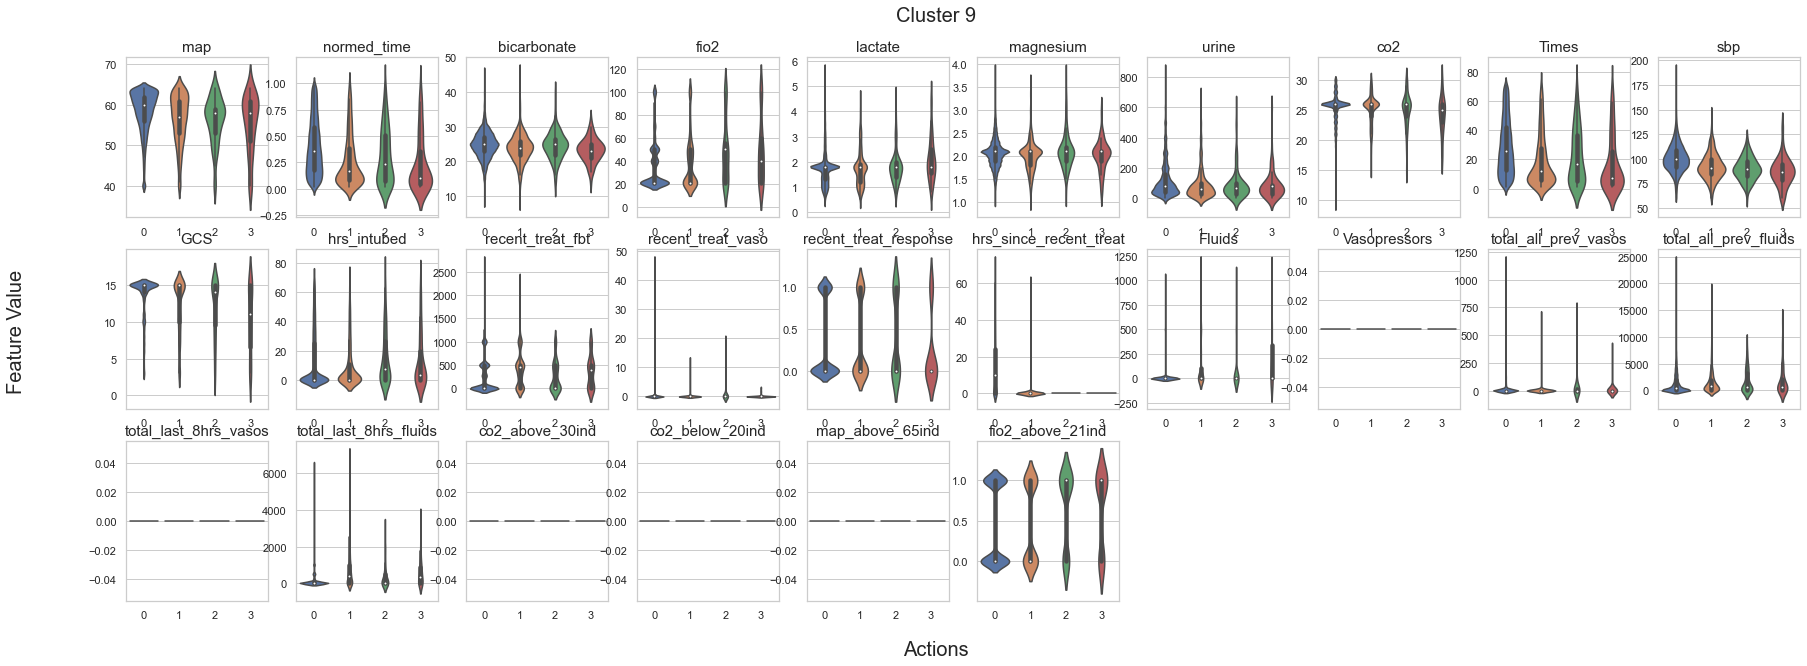

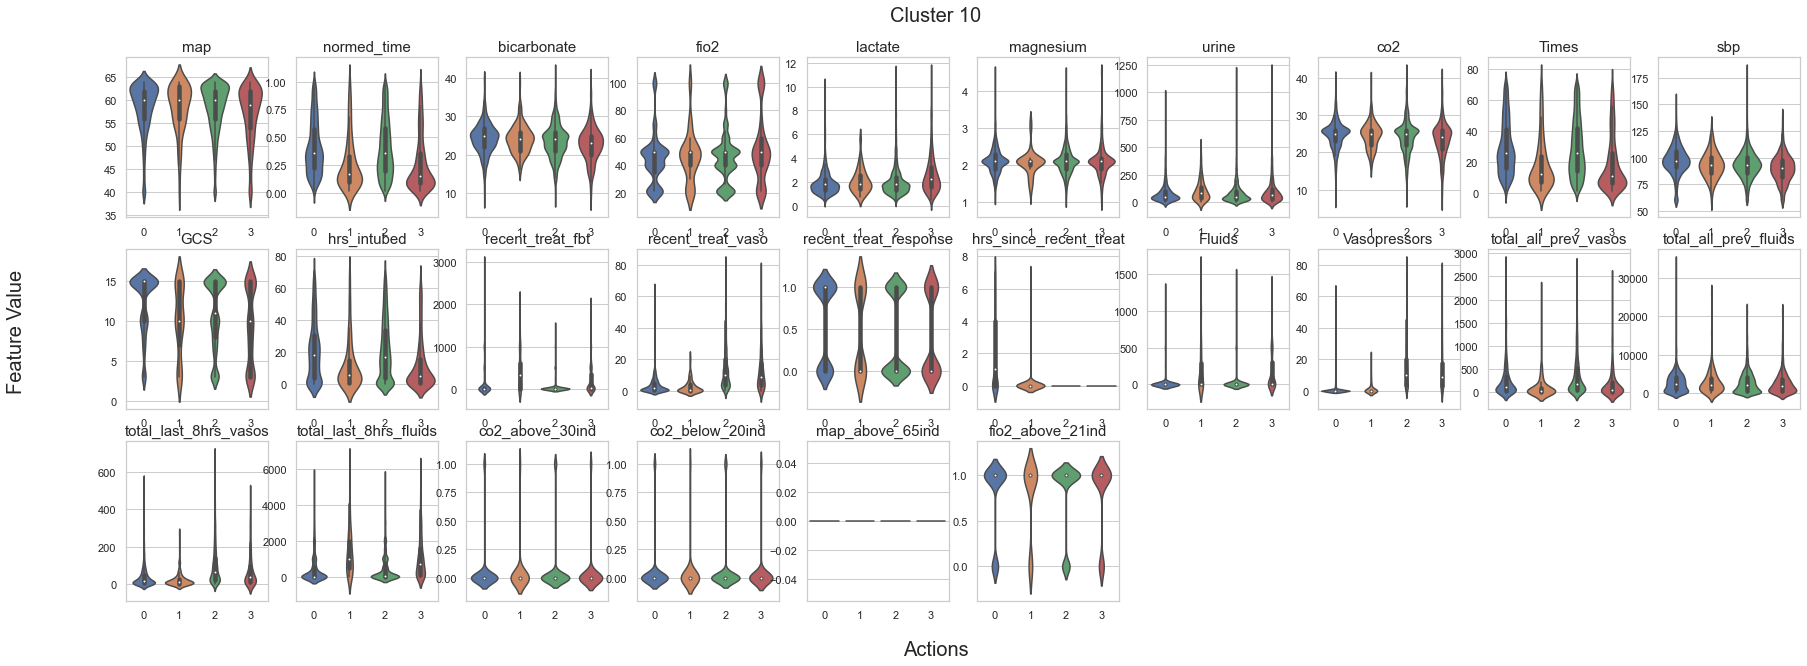

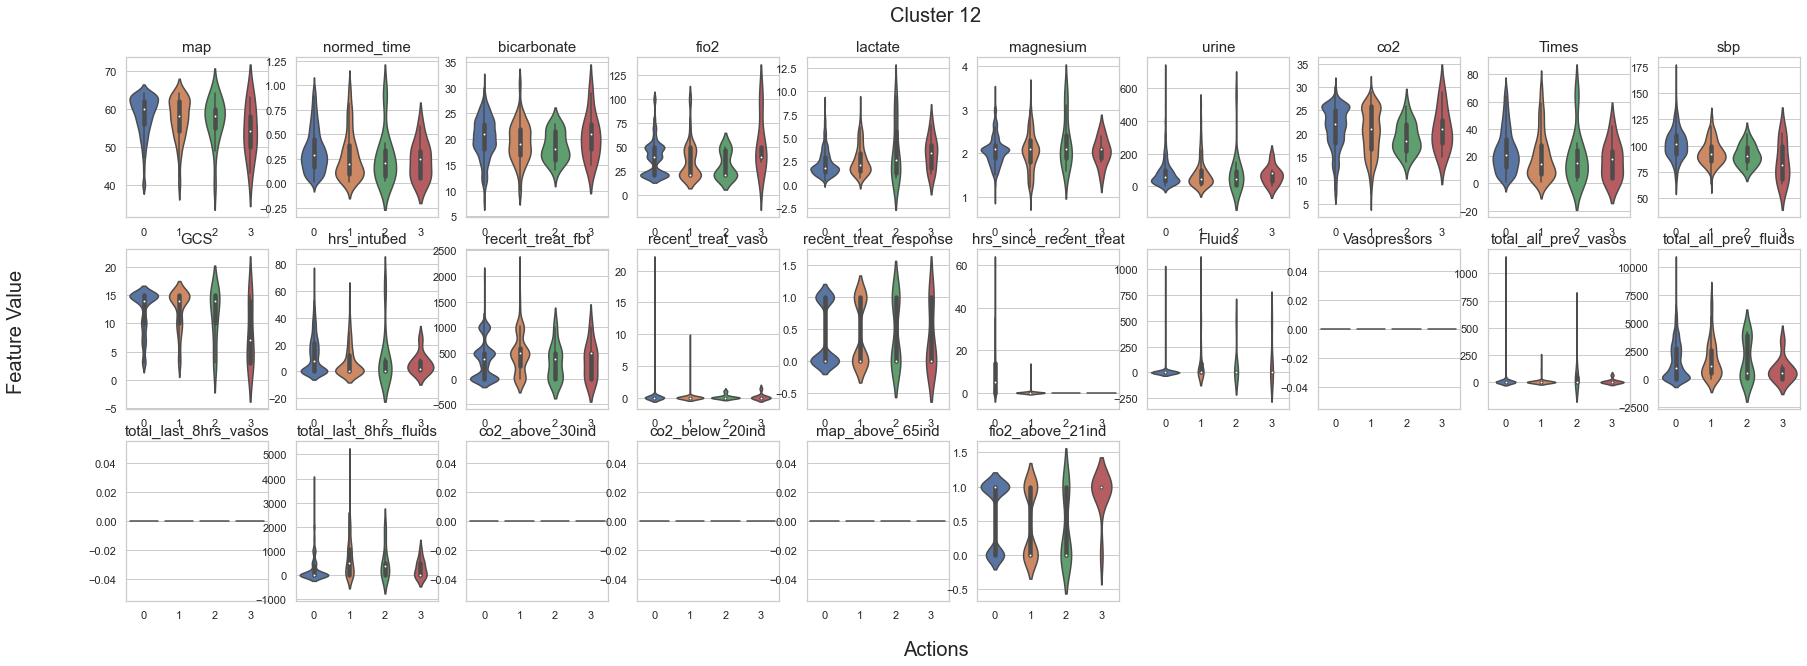

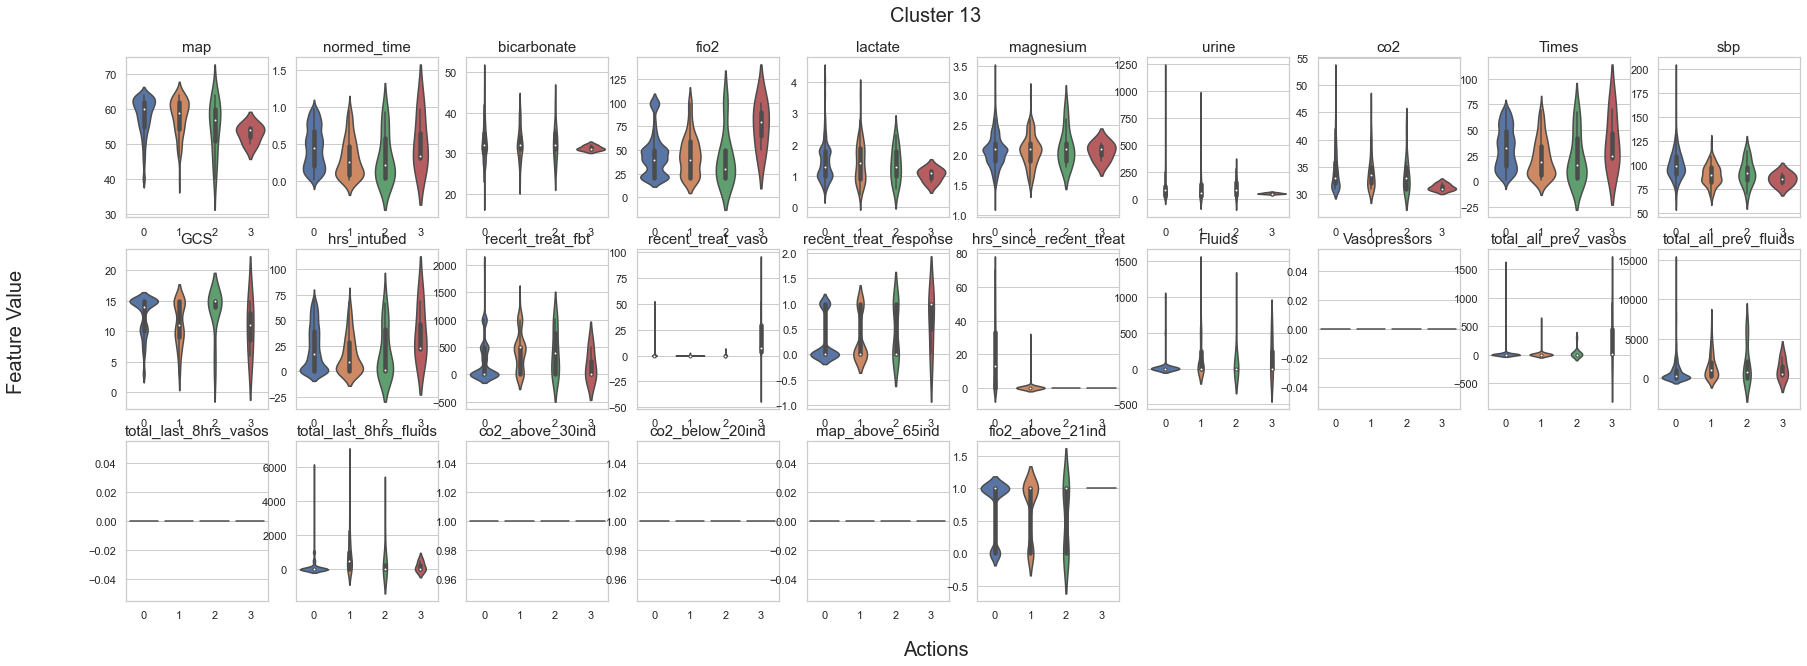

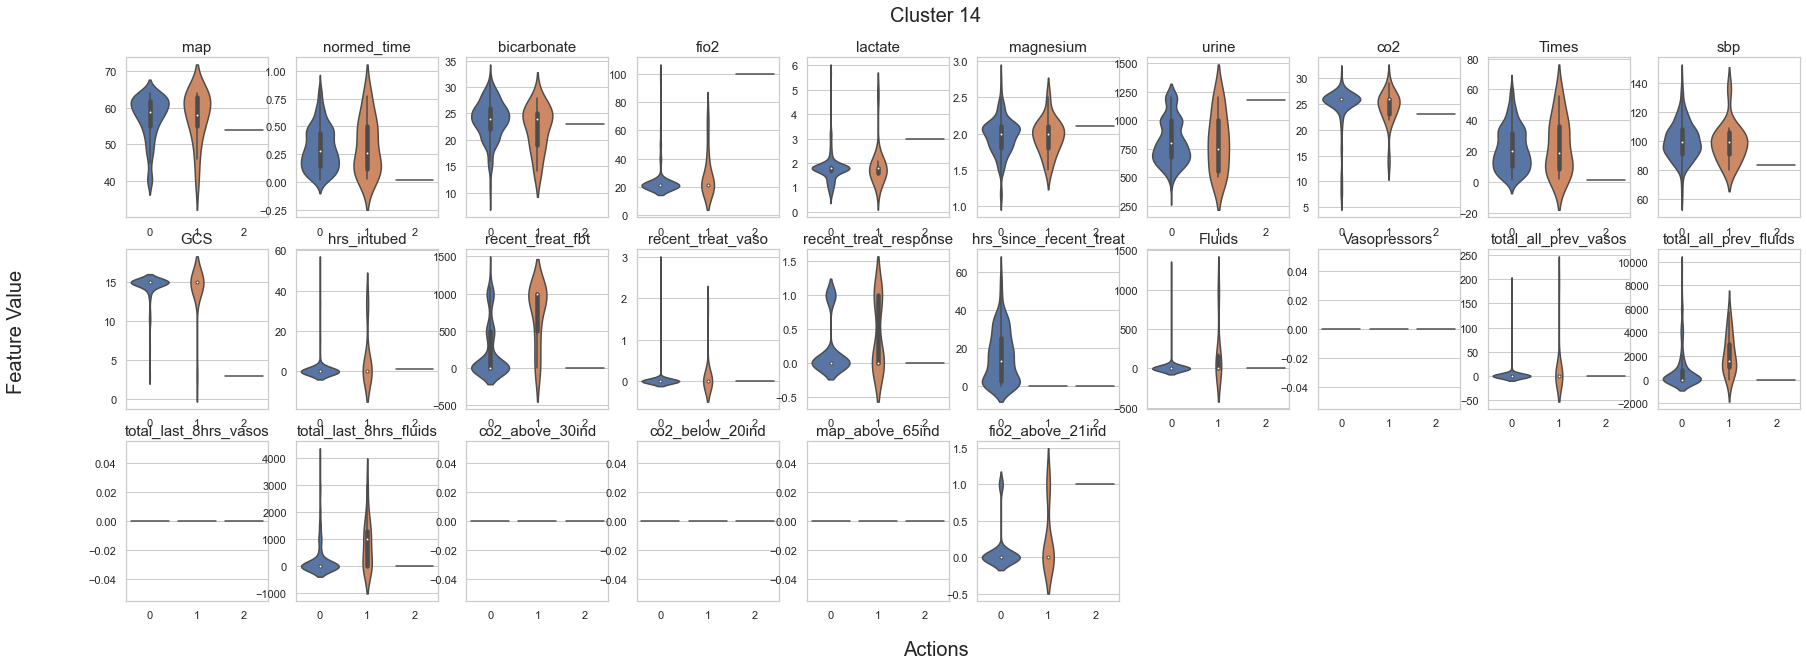

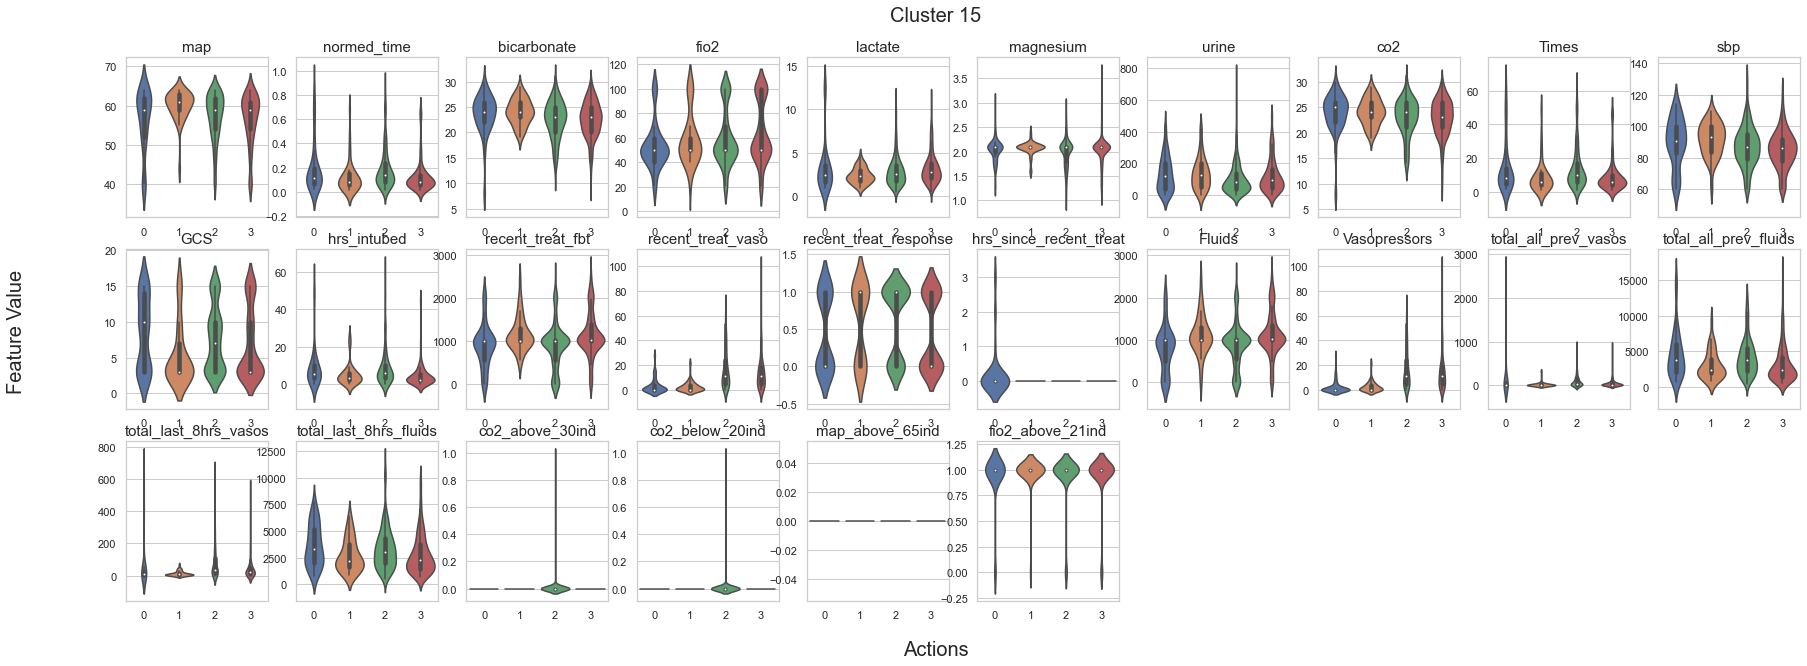

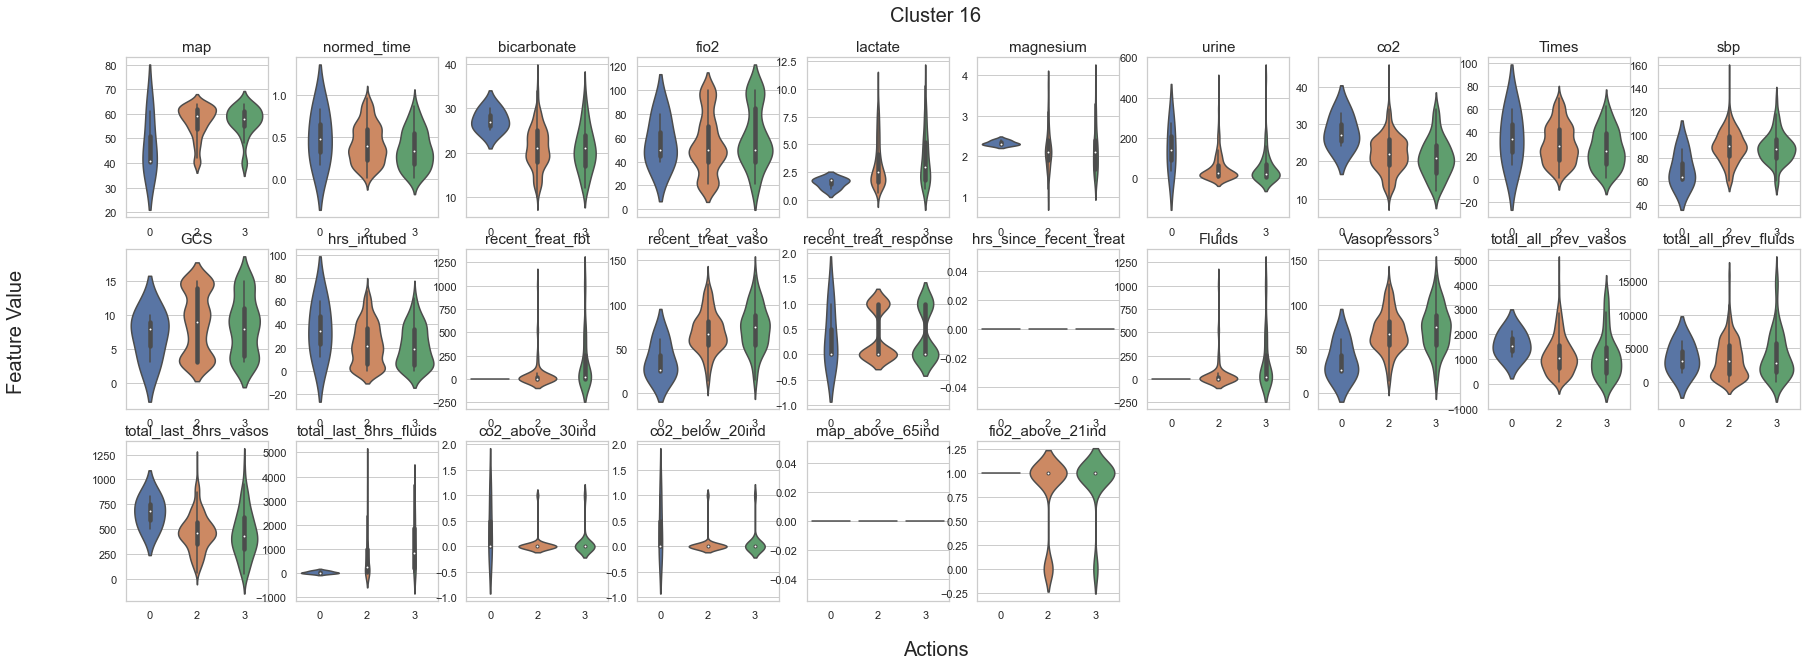

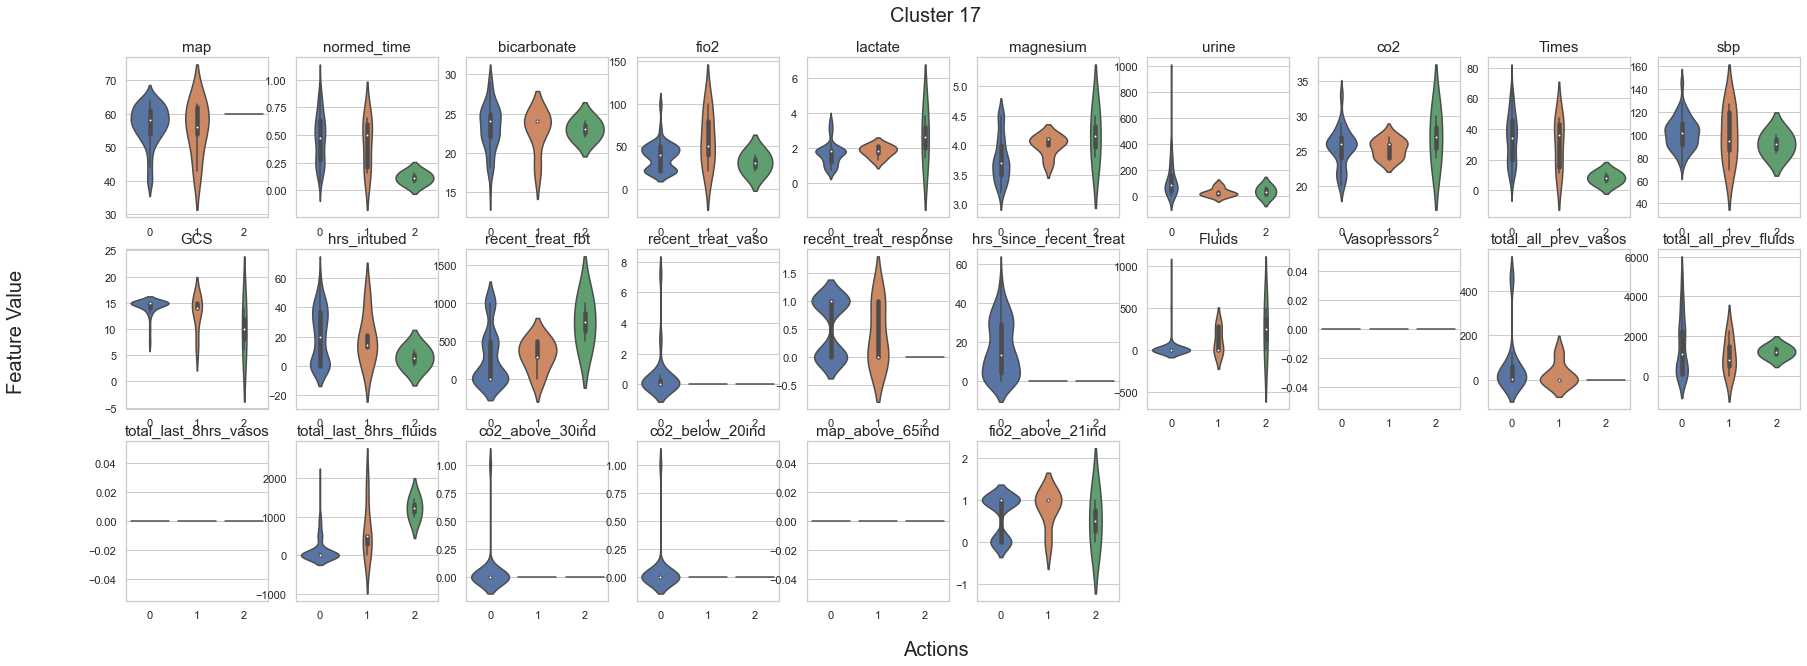

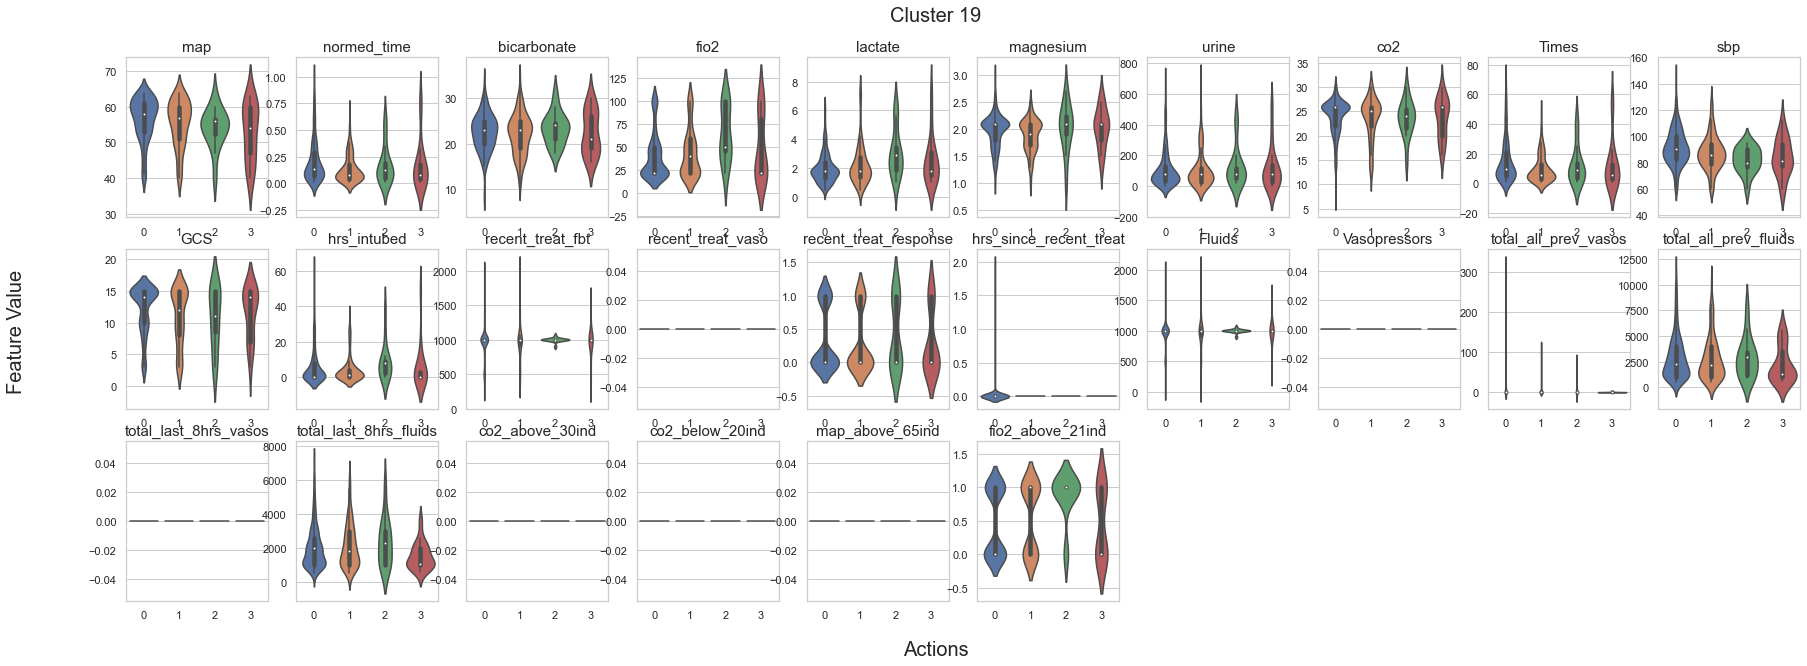

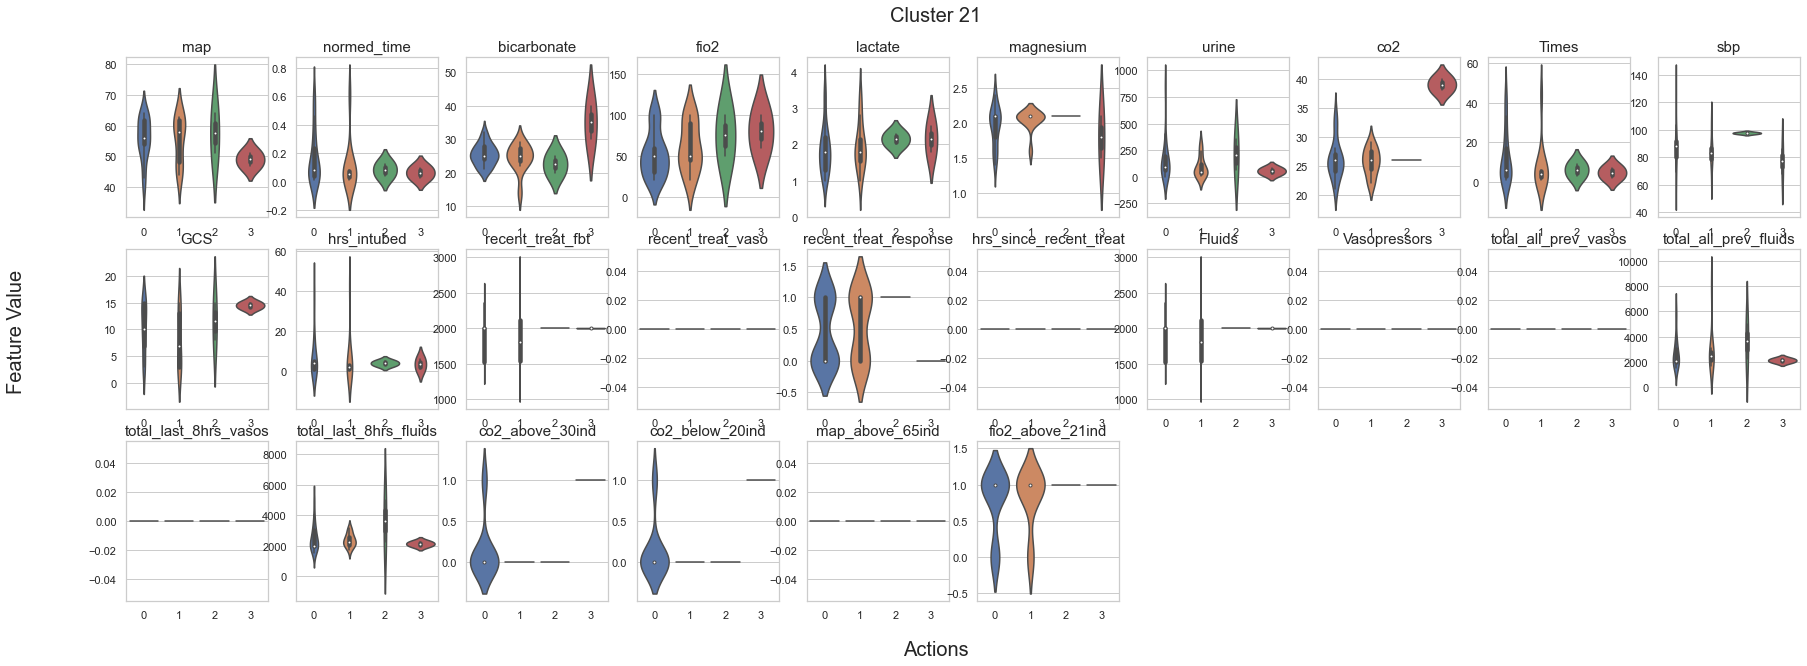

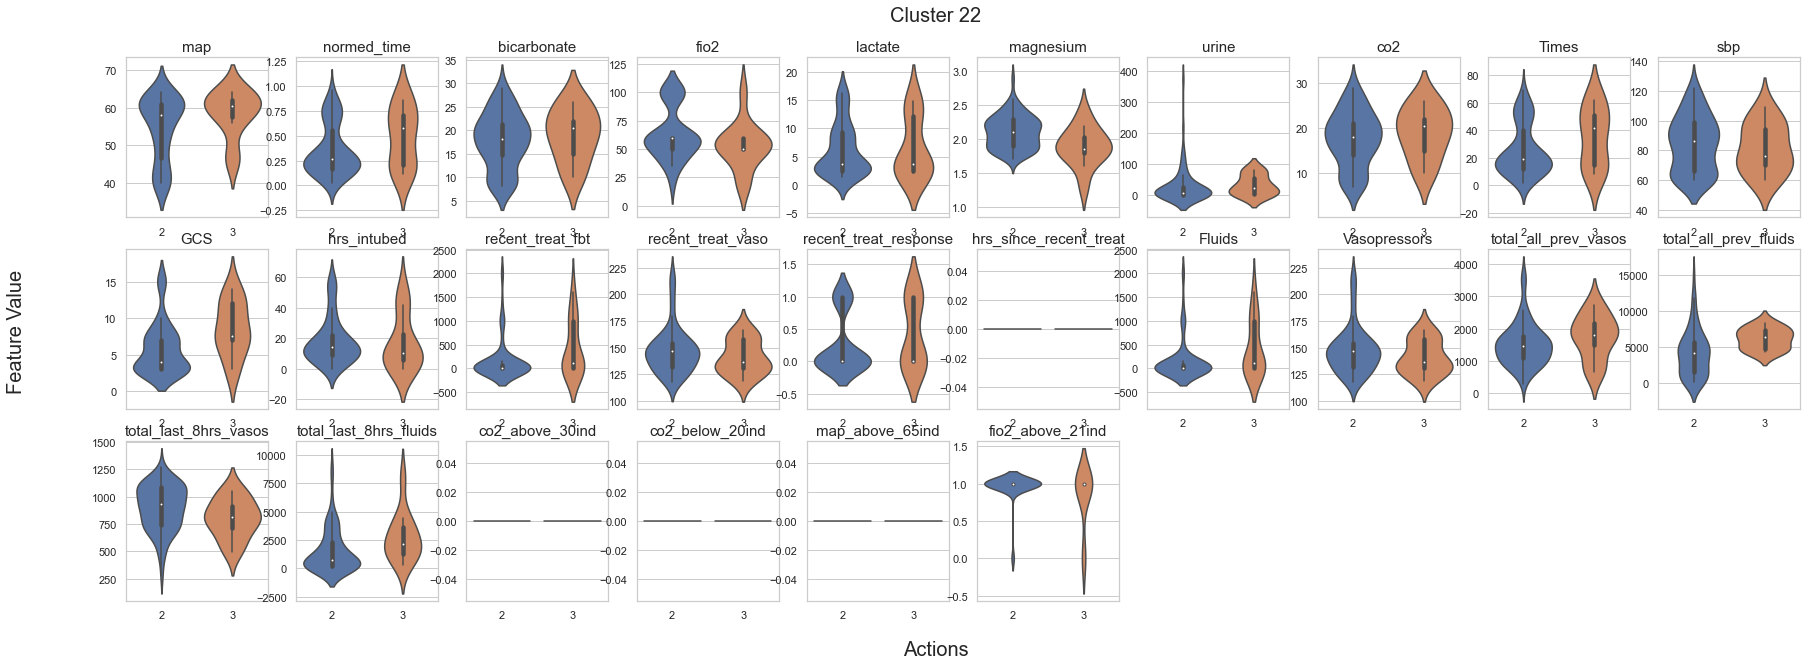

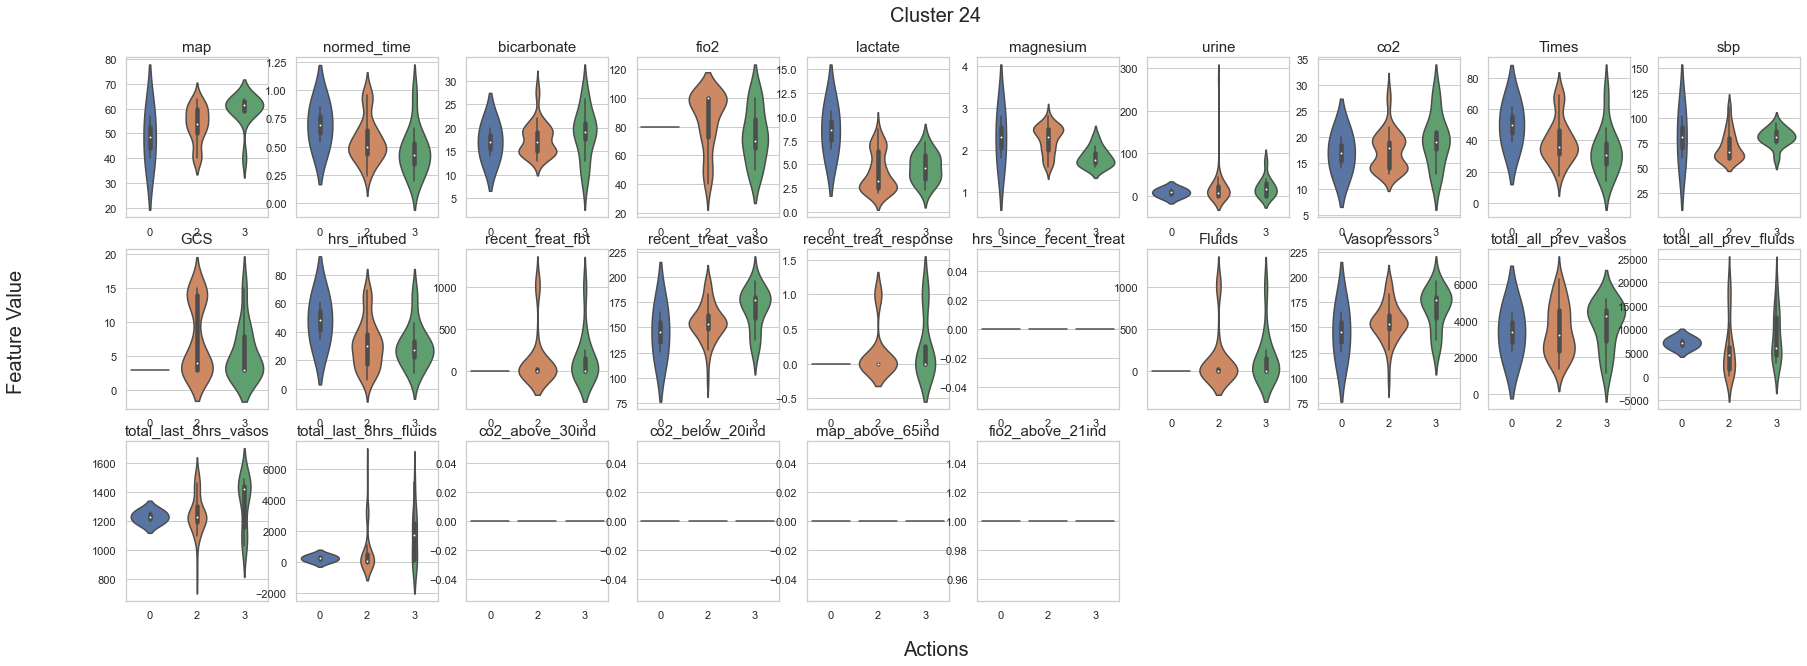

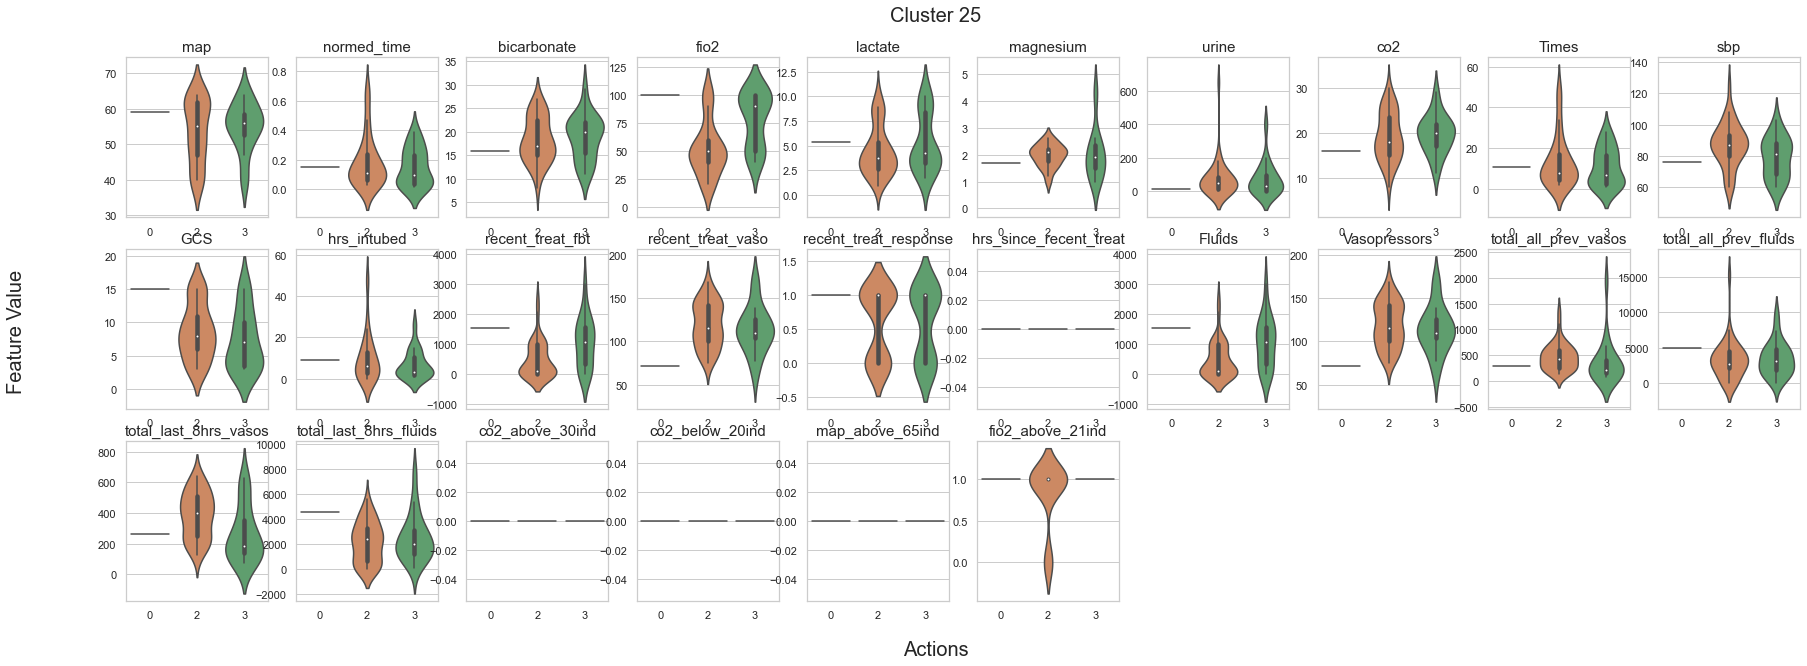

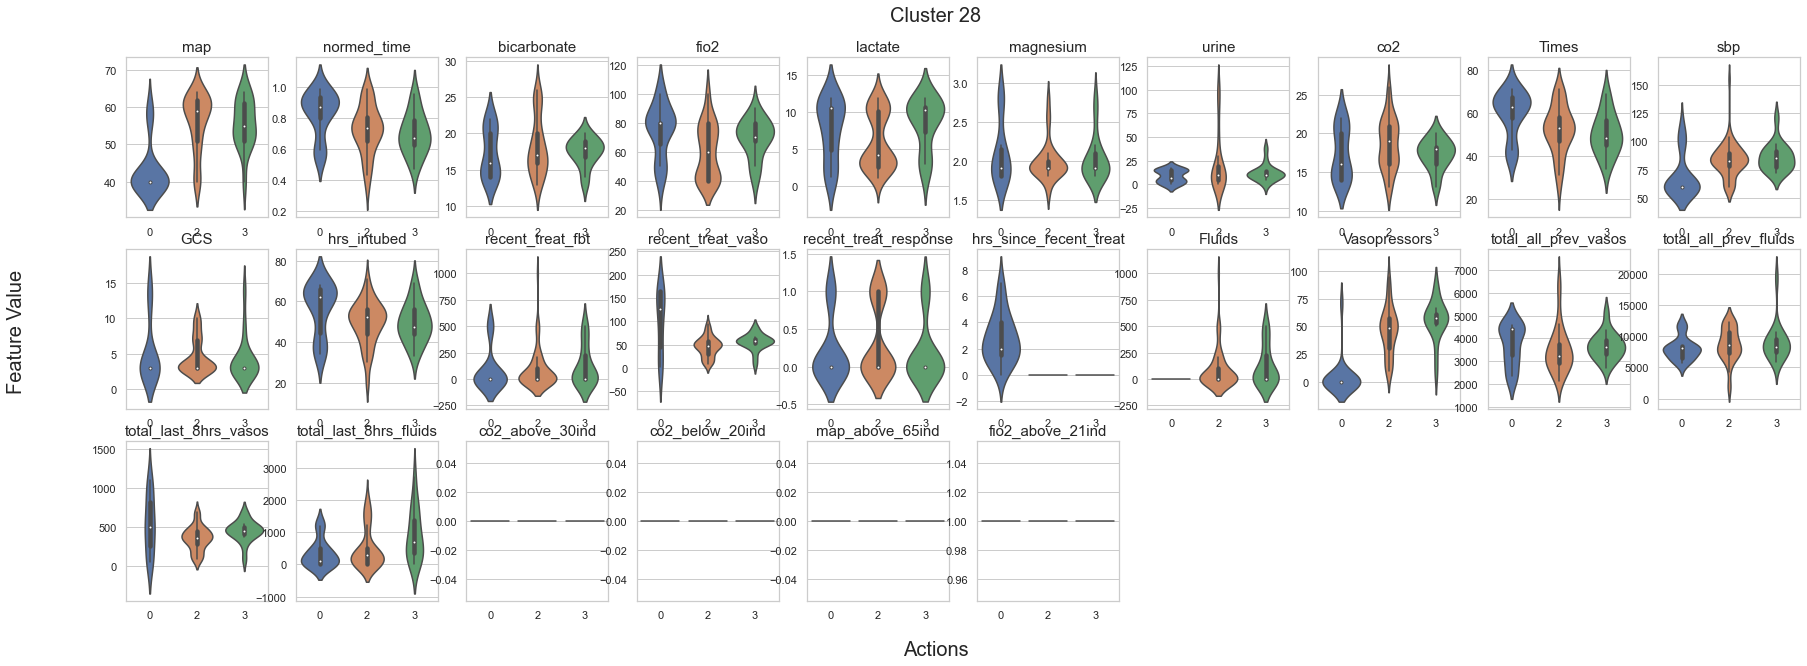

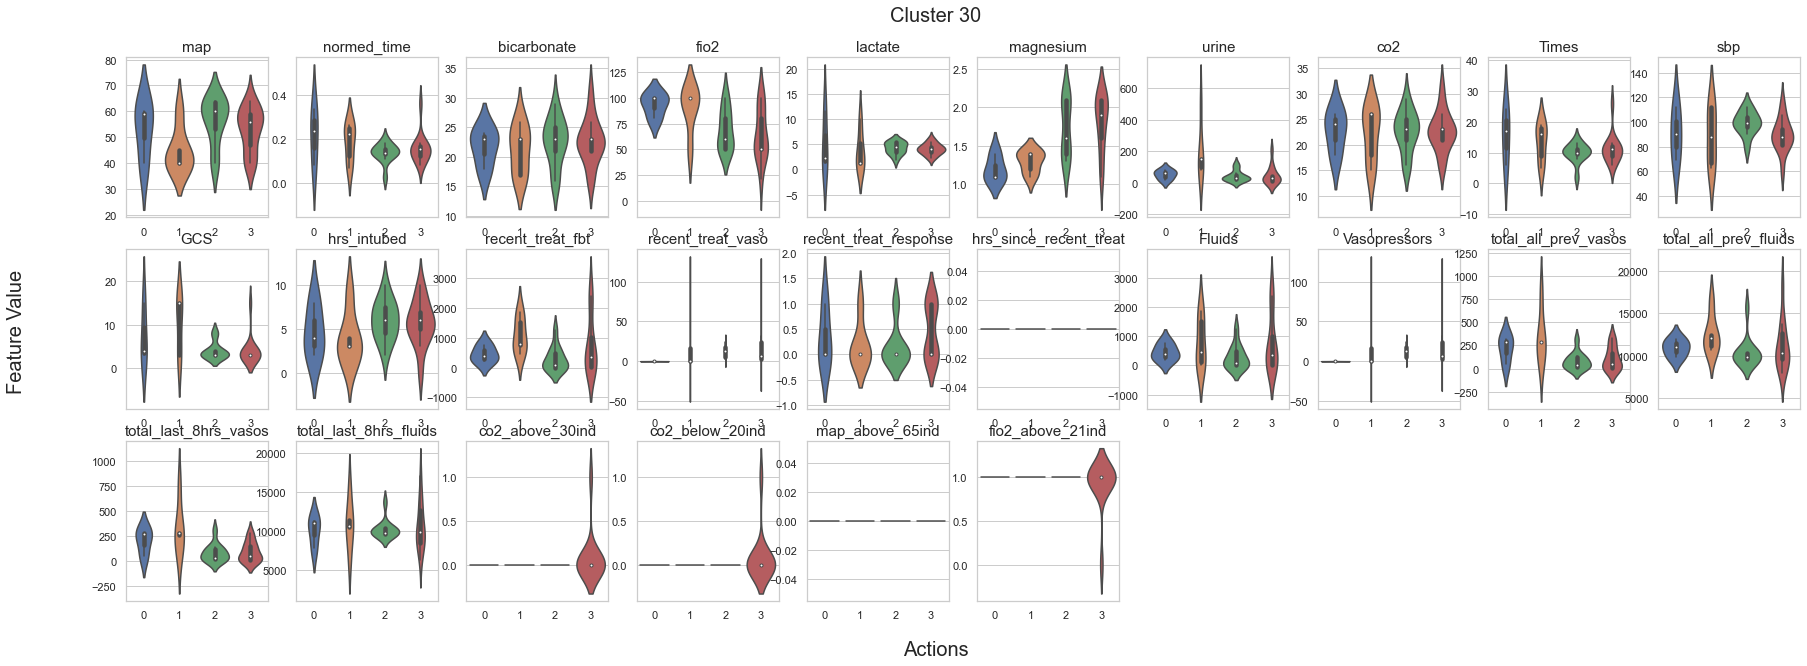

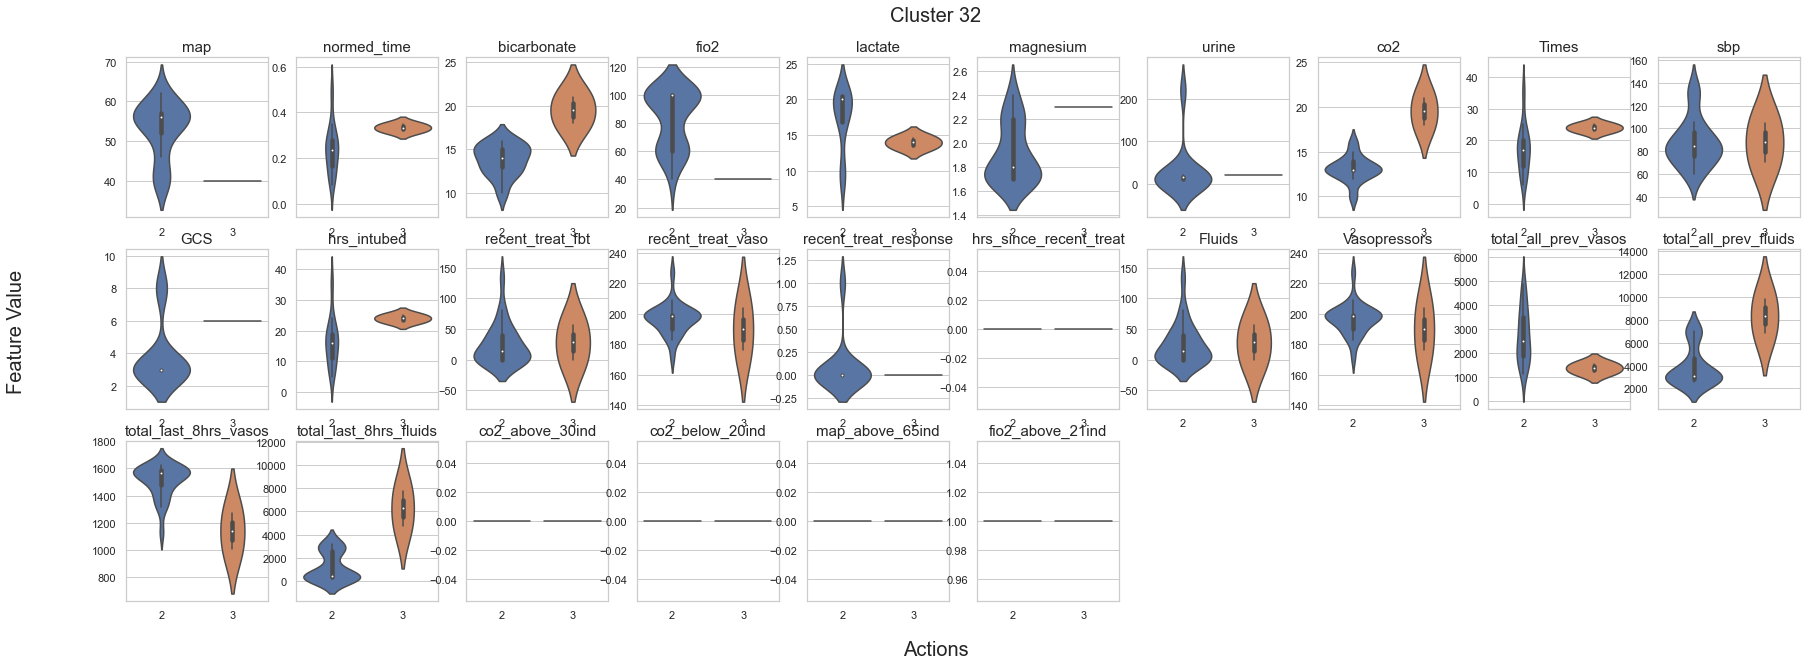

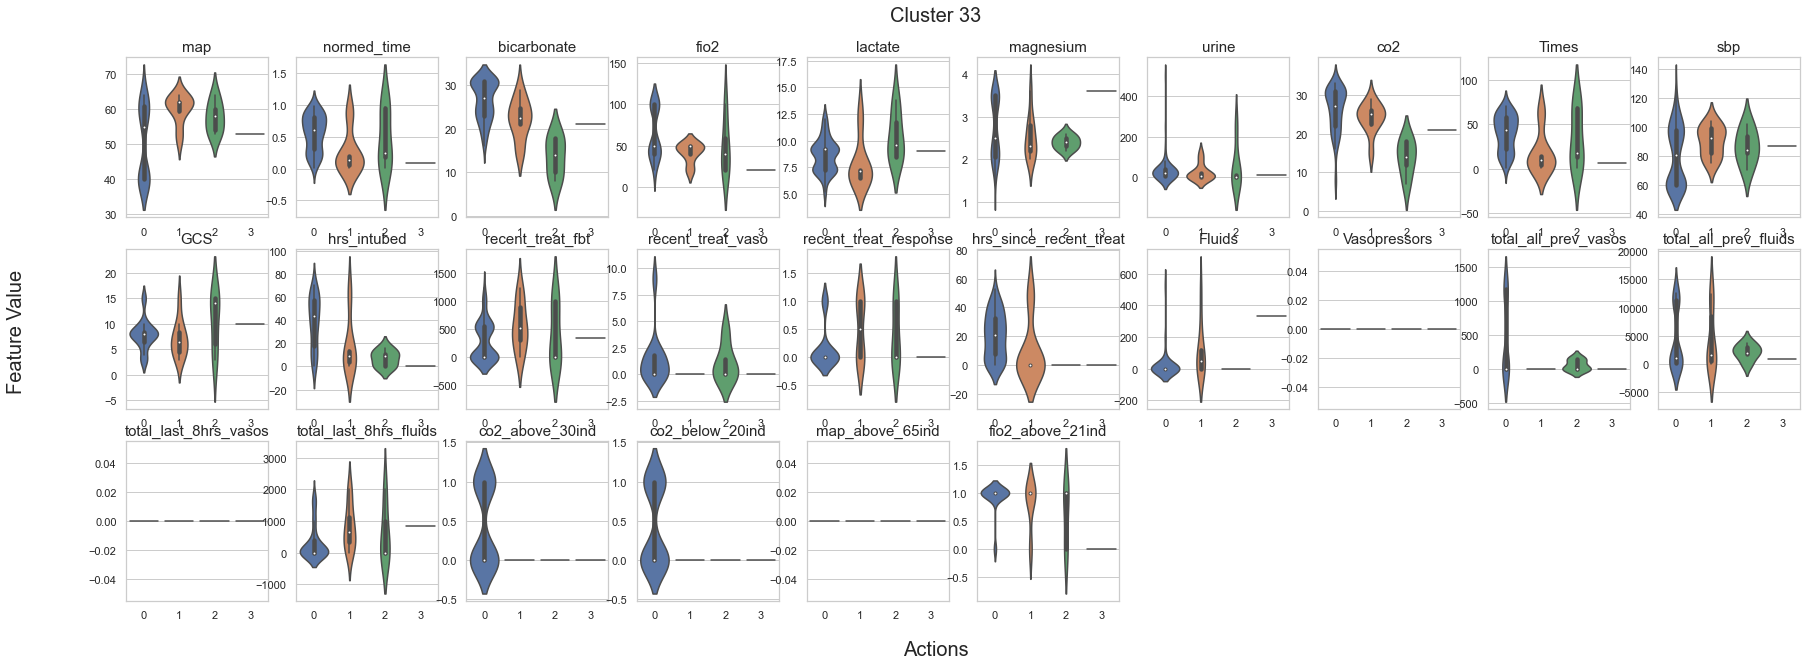

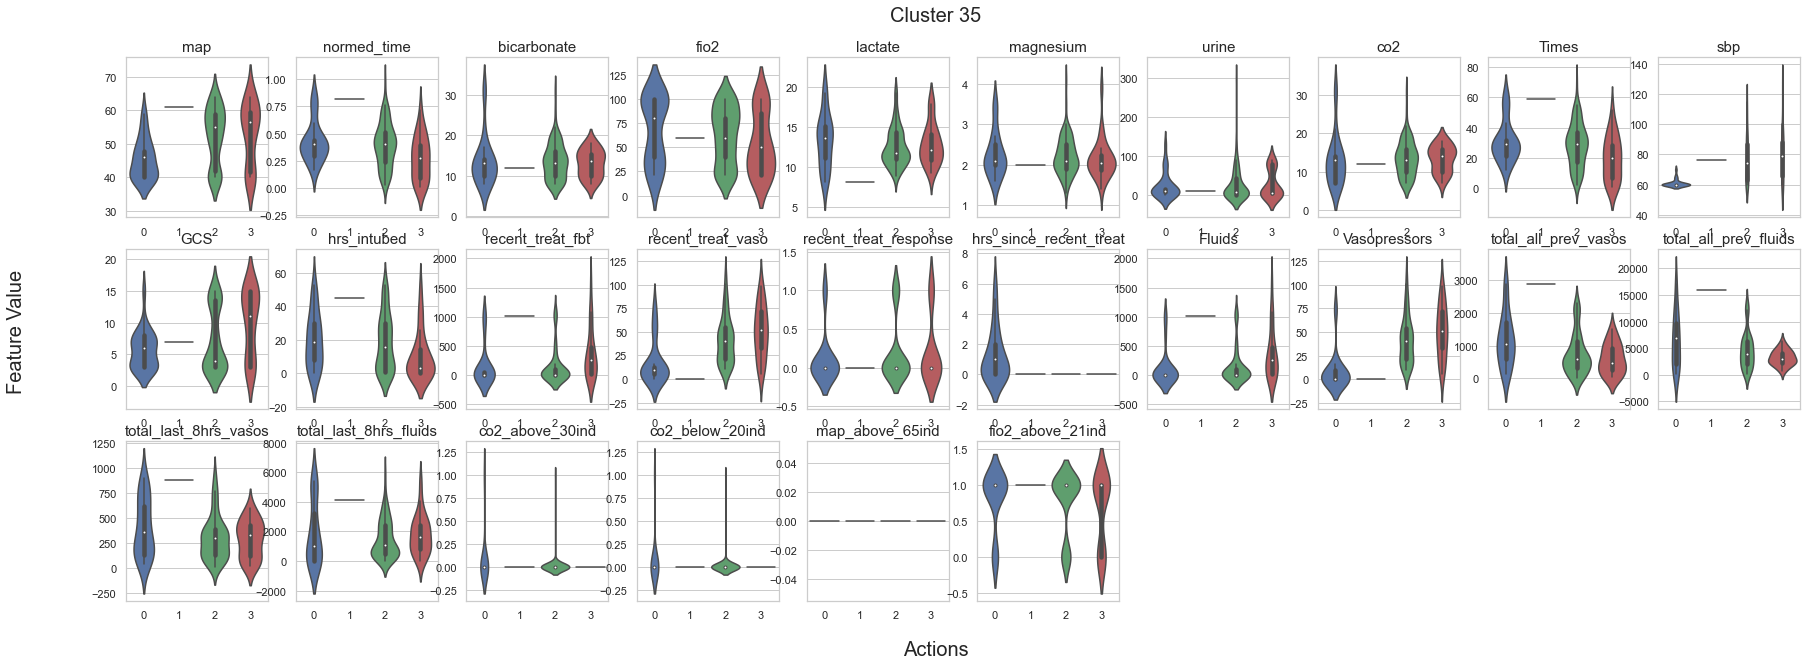

<IPython.core.display.Javascript object>

In [56]:
a_binned = summarize_actions(A_dp)

for i in range(len(np.unique(S1_labels_ordered))):
    dc_idx = np.where(S1_labels_ordered == i)[0]
    s1_viz_dc = S1_viz_dp[dc_idx, :]
    a_dc = a_binned[dc_idx]

    if len(dc_idx) > 20:
        eval_split(i, s1_viz_dc, a_dc)

#### Quantify the difference of features in clusters

In [51]:
cluster_to_state = {
    x: y for x, y in zip(viz_include_clusters, range(len(viz_include_clusters)))
}

<IPython.core.display.Javascript object>

In [57]:
cluster_viz = []
cluster_max_diff = []
feat_var = np.var(S1_viz_dp, axis=0)


for i in range(len(np.unique(S1_labels_ordered))):
    dc_idx = np.where(S1_labels_ordered == i)[0]
    s1_ori_dc = S1_viz_dp[dc_idx, :]
    a_dc = a_binned[dc_idx]

    if len(dc_idx) > 10 and i in included_clusters:
        name = f'Cluster{i}:('
        mean_mat = []
        for a in range(4):
            a_idx = np.where(a_dc == a)[0]
            name += f'{a}:{len(a_idx)}, ' if a != 3 else f'{a}:{len(a_idx)})'
            if len(a_idx) > 0:
                s1_ori_a = s1_ori_dc[a_idx, :]
                mean_mat.append(list(np.mean(s1_ori_a, axis=0)))
        
        cluster_viz.append(name)
        mean_mat = np.array(mean_mat)
        max_diff = (np.max(mean_mat, axis=0) - np.min(mean_mat, axis=0)) / feat_var
        cluster_max_diff.append(list(max_diff))
        
cluster_max_diff = np.array(cluster_max_diff)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


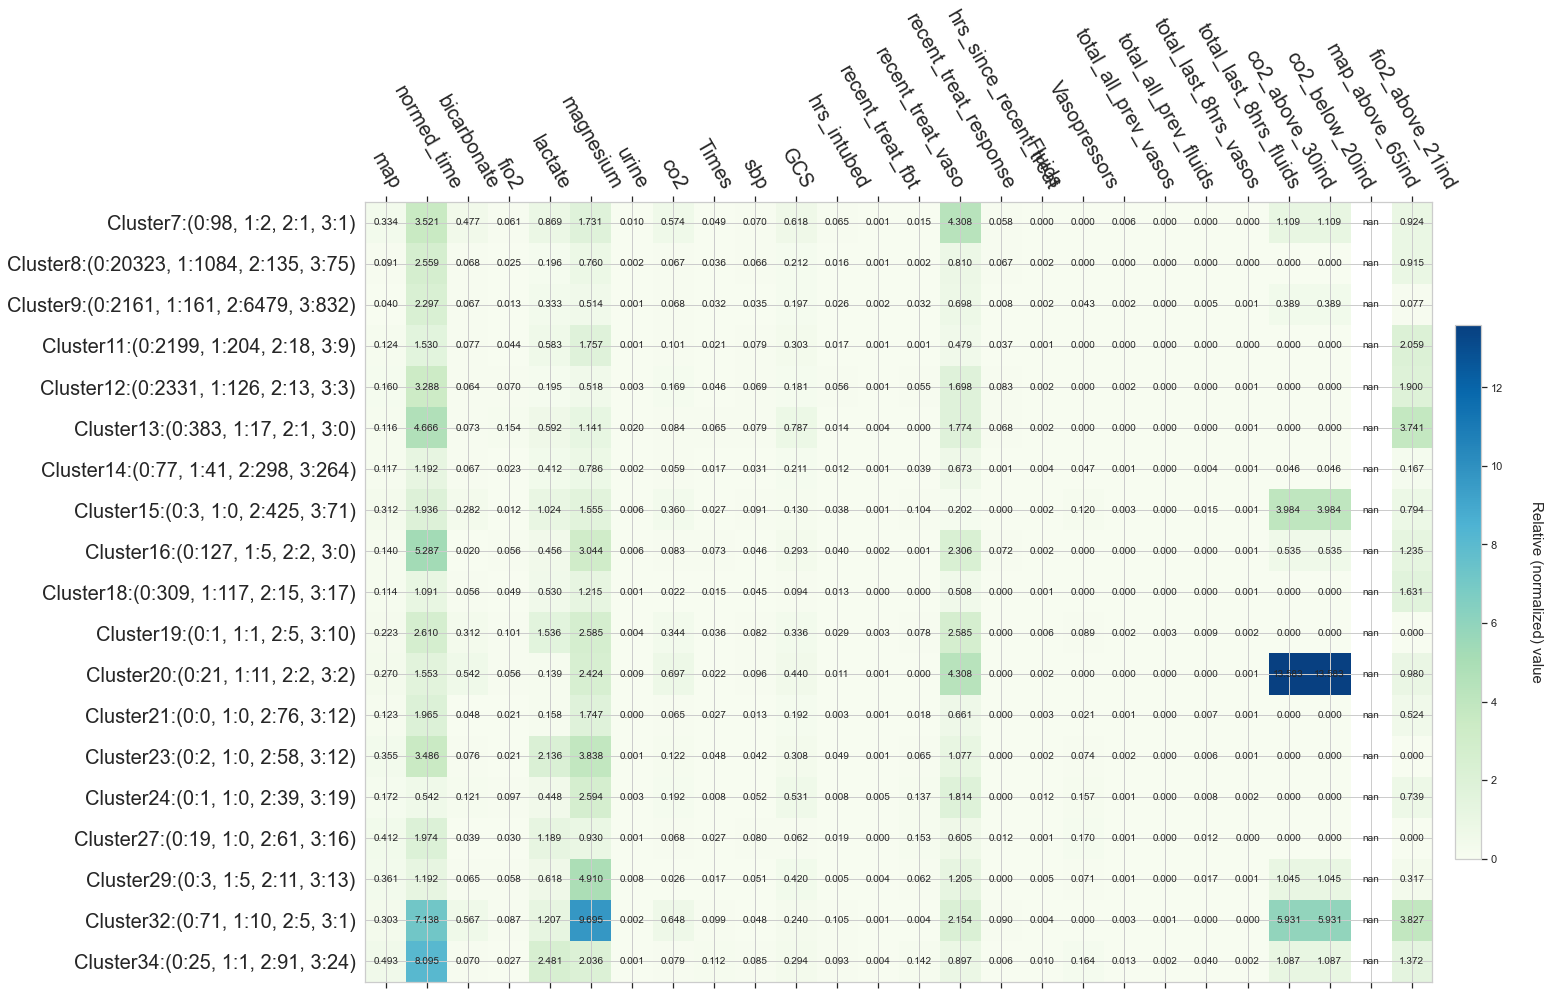

<IPython.core.display.Javascript object>

In [58]:
plt.figure(figsize=(20, 20))
im = plt.matshow(cluster_max_diff, cmap="GnBu", fignum=1)
col_len = cluster_max_diff.shape[1]
cluster_len = cluster_max_diff.shape[0]

for c in range(cluster_len):
    for d in range(col_len):
        plt.text(
            d,
            c,
            "{:0.3f}".format(cluster_max_diff[c, d]),
            ha="center",
            va="center",
            fontsize=10,
        )
cbar = plt.colorbar(im, fraction=0.0239, pad=0.02)
cbar.ax.set_ylabel(
    "Relative (normalized) value", rotation=270, fontsize=15, labelpad=40
)
plt.yticks(range(cluster_len), cluster_viz, fontsize=20)
plt.xticks(range(col_len), column_names_noind, fontsize=20, rotation=300)
plt.tick_params(axis="x", labelbottom=False, labeltop=True)
plt.savefig(f"../results/visualization/Cluster_feat_diff_kernel_{version_date}.png")

#### TSNE

/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


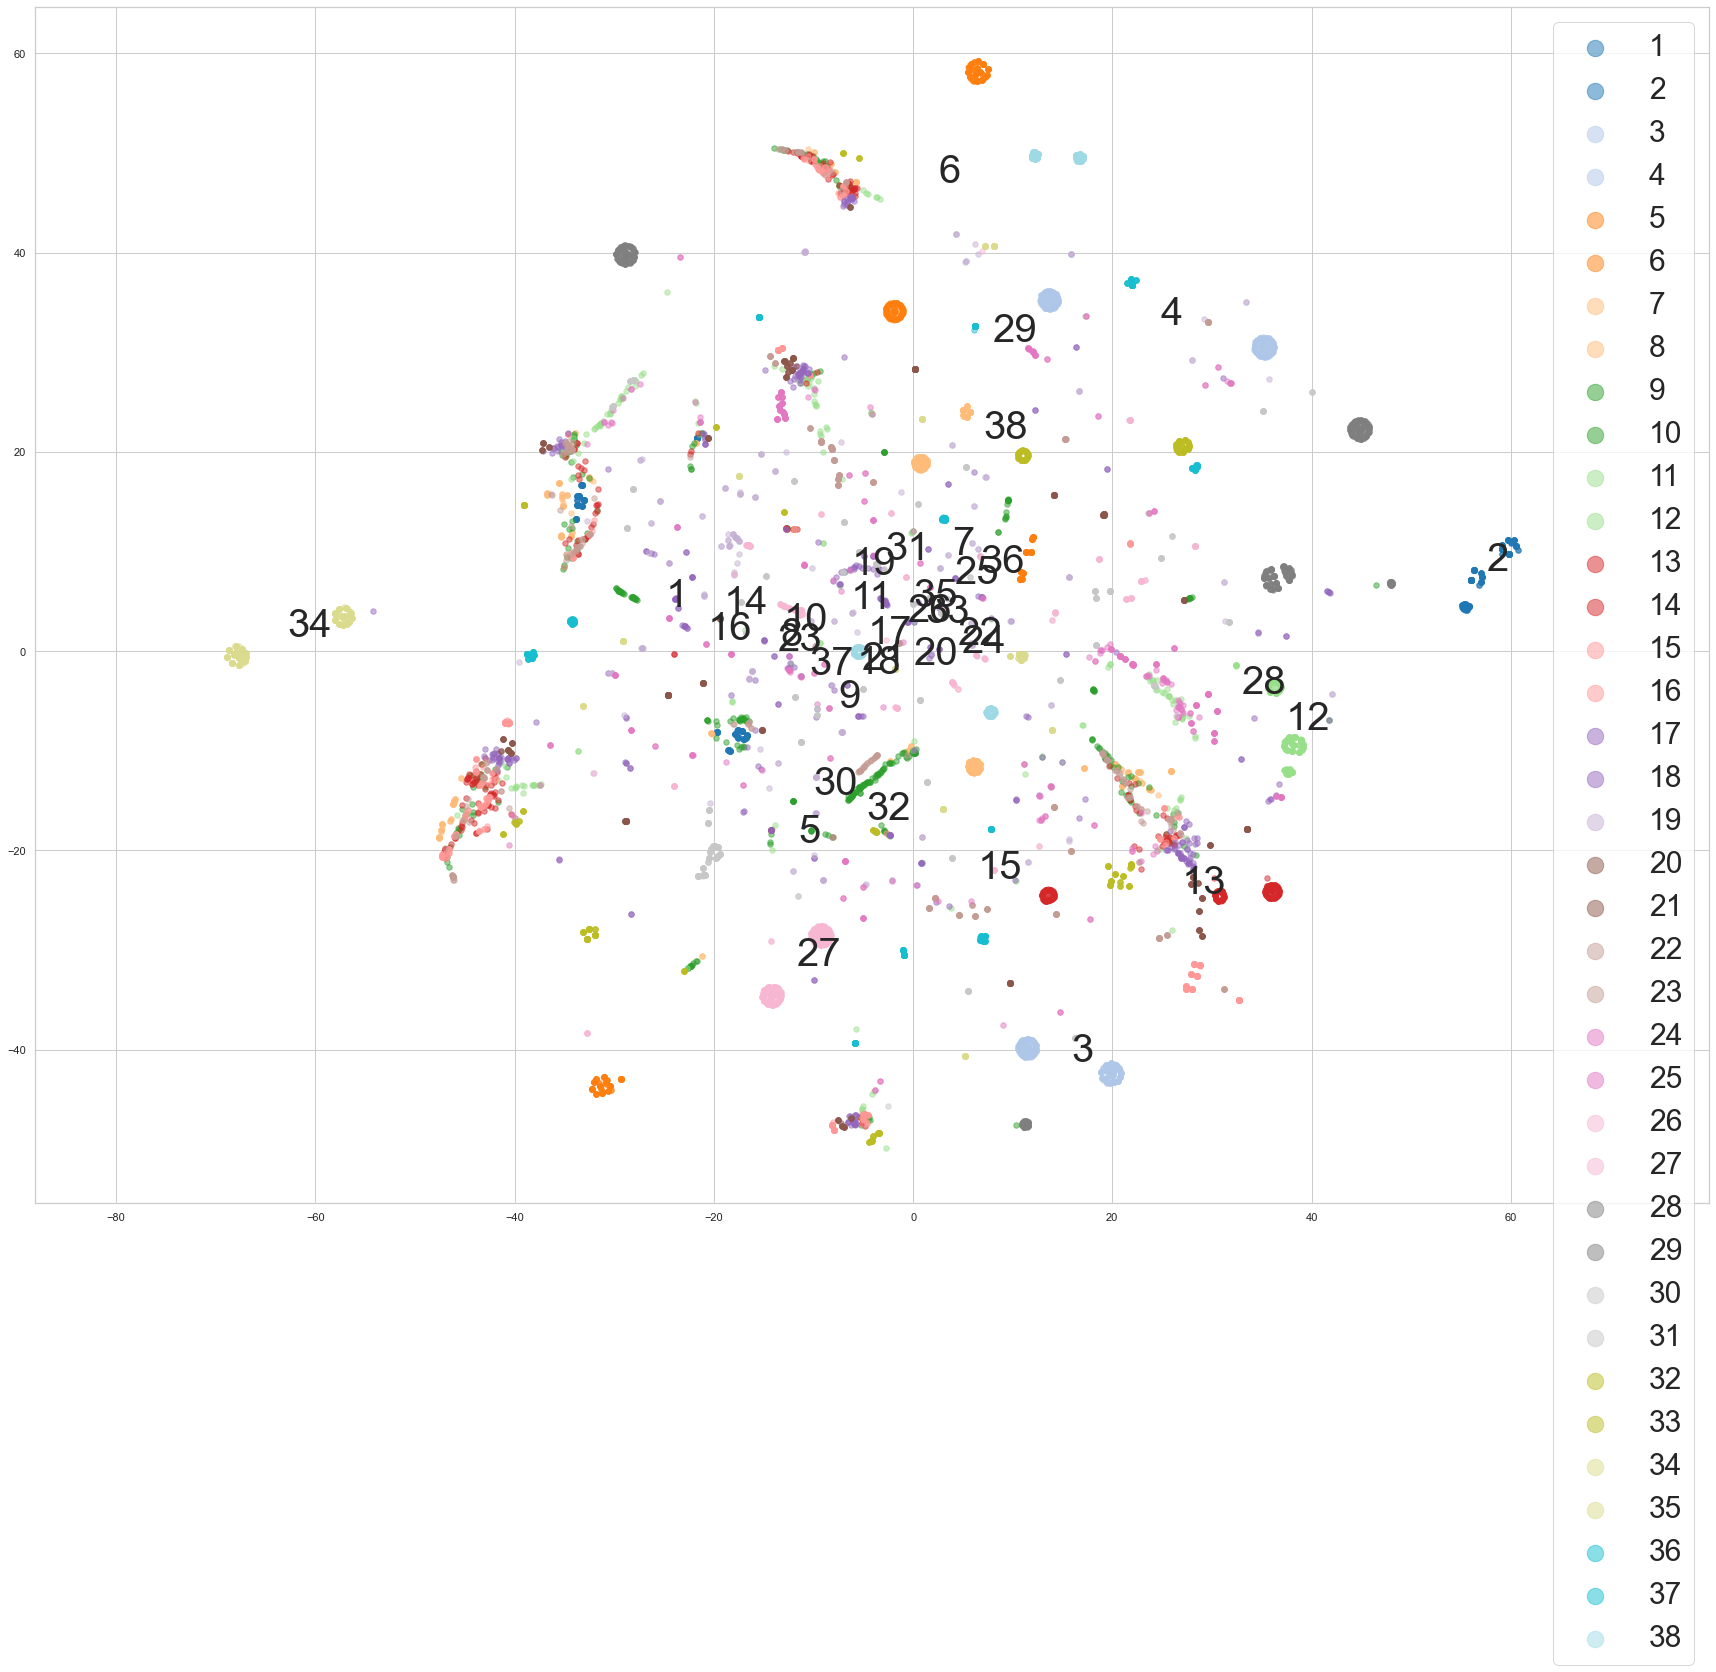

<IPython.core.display.Javascript object>

In [240]:
draw_tsne(Z1, S1_labels_ordered, f"TSNE_{version_date}")

#### Plot Cluster Cycles

In [59]:
cluster_loops = [[] for _ in range(k)]
for _, values in patient_clusters.items():
    current_cluster = {}
    for idx, cluster in enumerate(values):
        if cluster in current_cluster and current_cluster[cluster] != idx - 1:
            cluster_loops[cluster].append(idx - current_cluster[cluster])
        current_cluster[cluster] = idx

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


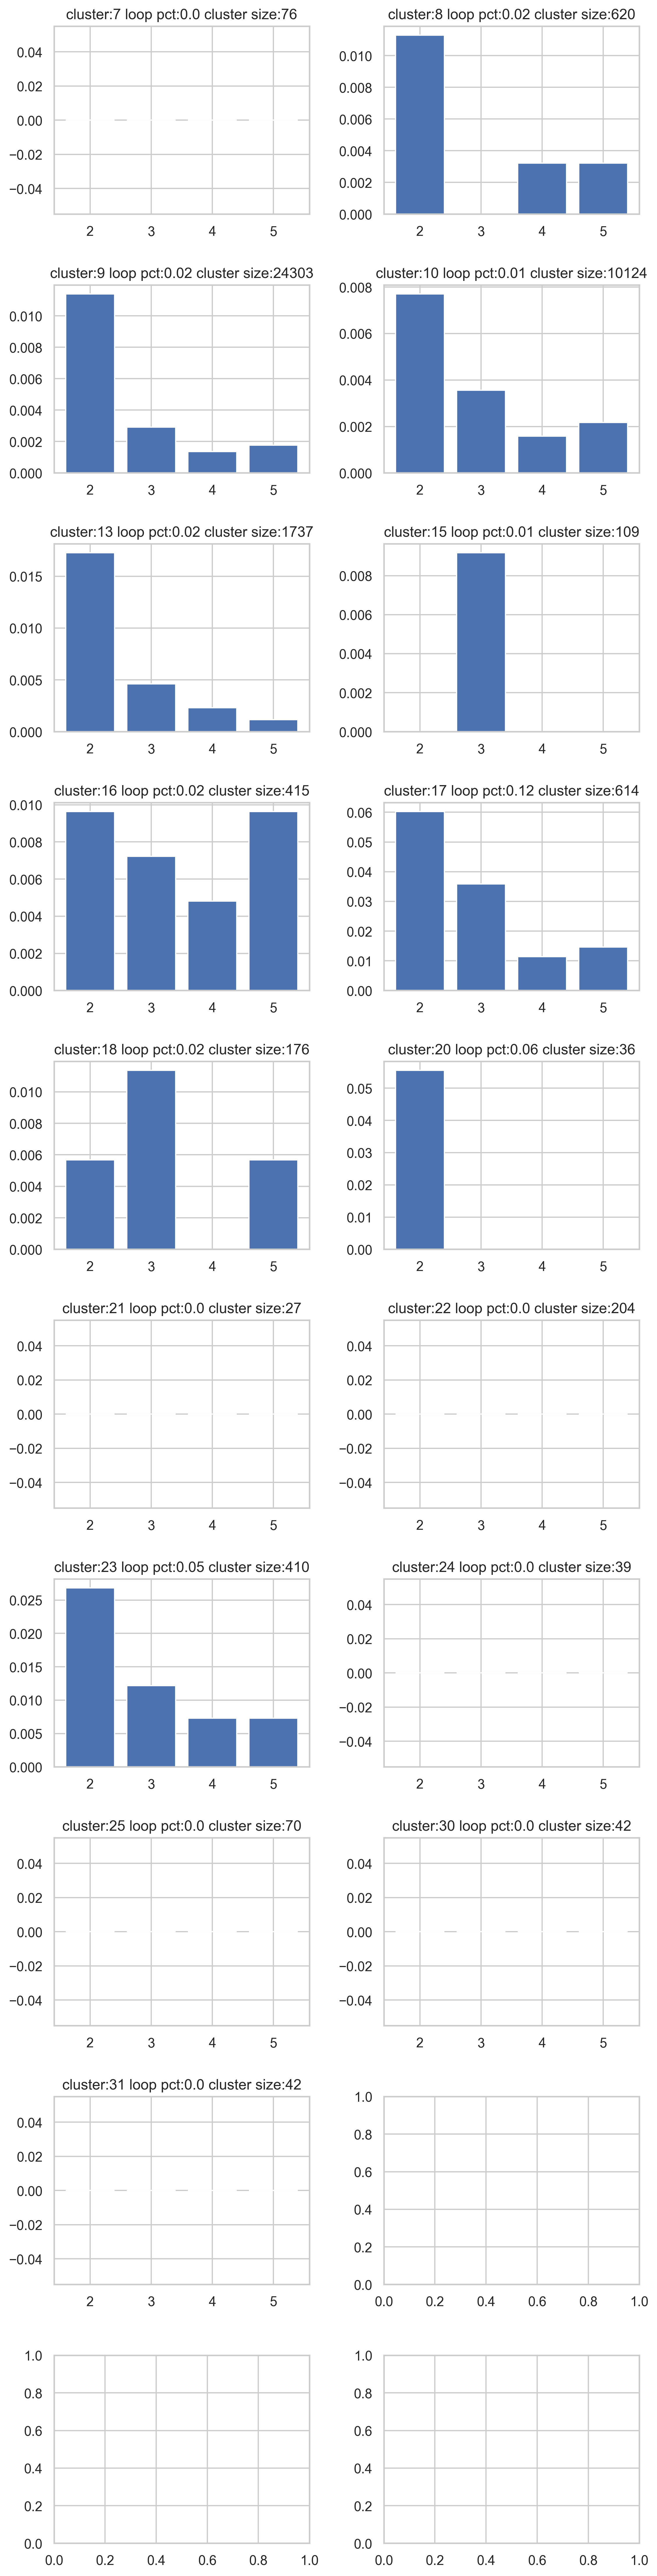

<IPython.core.display.Javascript object>

In [253]:
from collections import Counter

label_size = Counter(S1_labels_ordered)
fig, axs = plt.subplots(10, 2, figsize=(8, 30), dpi=300)
count = 0
for idx, cluster in enumerate(cluster_loops):
    if idx in included_clusters:
        hist_norm = np.histogram(cluster, range=(2, 6), bins=4)[0] / label_size[idx]
        # axs[idx // 2, idx % 2].hist(cluster, range=(0, 5))
        loop_pert = np.sum(1 for x in cluster if x <= 5)
        axs[count // 2, count % 2].bar(np.arange(2, 6), hist_norm)
        axs[count // 2, count % 2].set_title(
            f"cluster:{idx} loop pct:{round(loop_pert / label_size[idx], 2)} cluster size:{label_size[idx]}"
        )
        count += 1
fig.tight_layout(pad=2.0)
plt.savefig(f"../results/visualization/Looping_analysis_{version_date}.png")

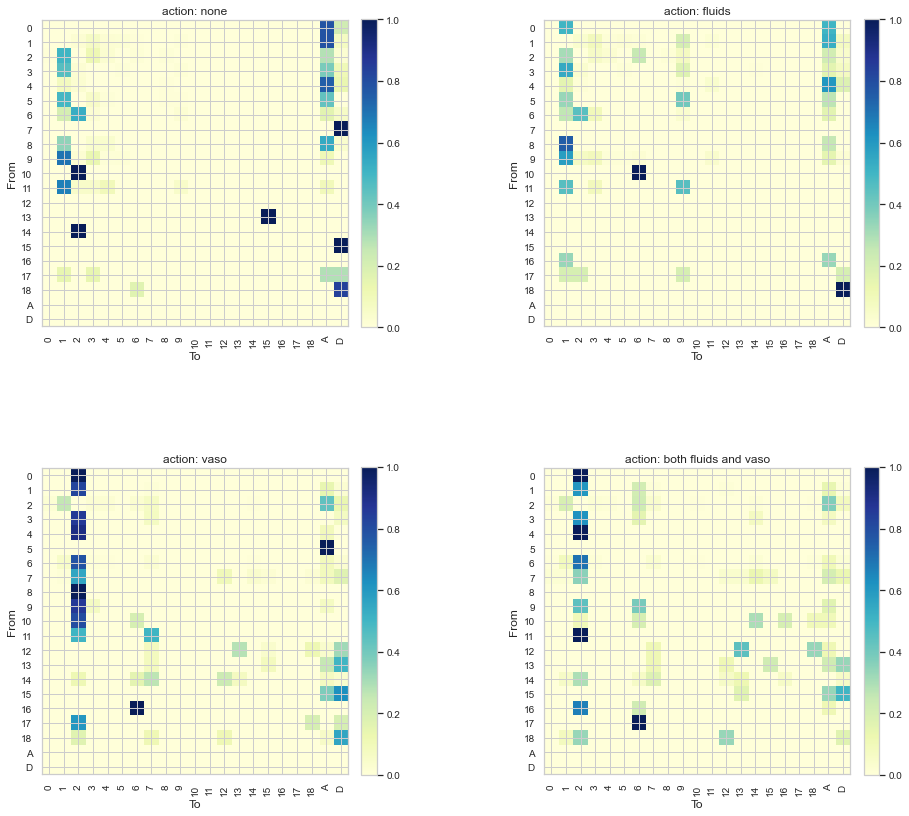

<IPython.core.display.Javascript object>

In [69]:
matplotlib.rc("xtick", labelsize=10)
matplotlib.rc("ytick", labelsize=10)
from mdp_visualization import visualize_mdp_matrix

visualize_mdp_matrix(tmat_large_only, width=15, height=20)

#### Transition Plots

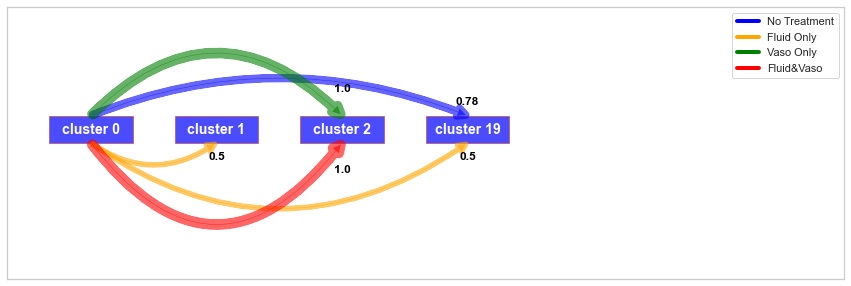

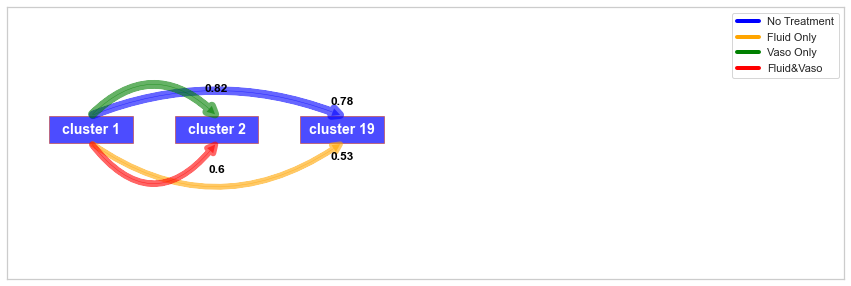

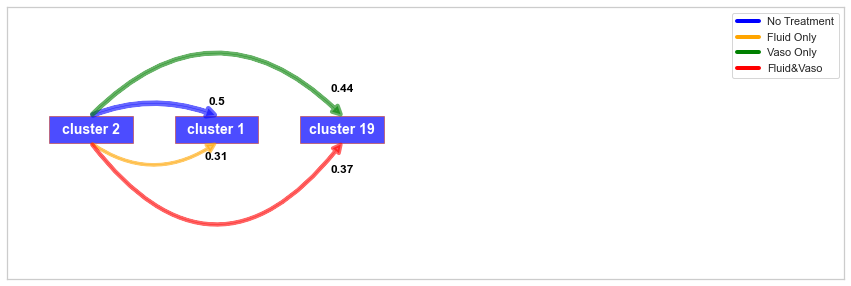

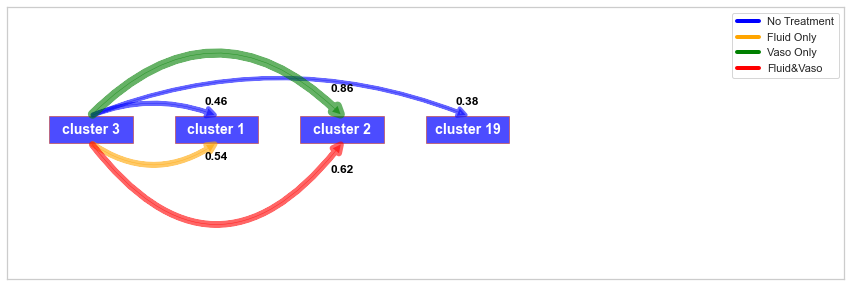

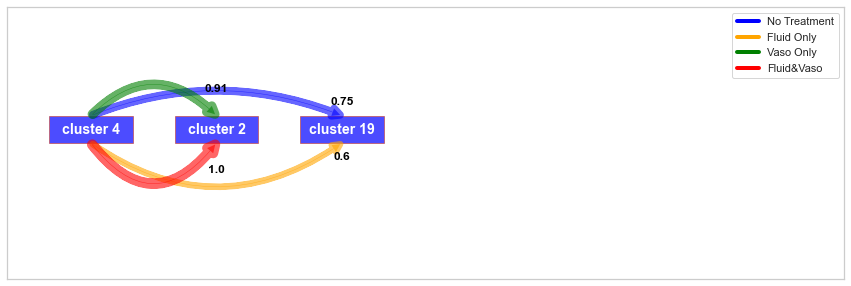

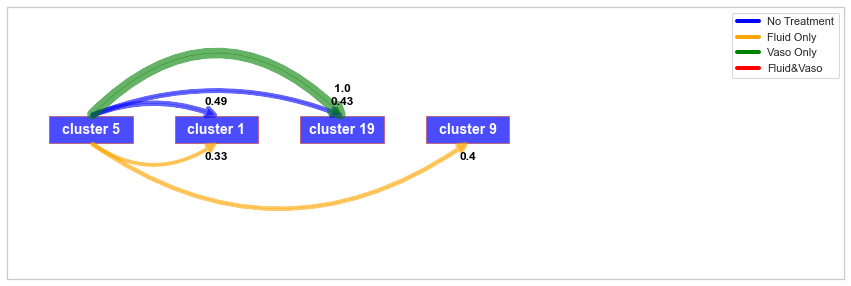

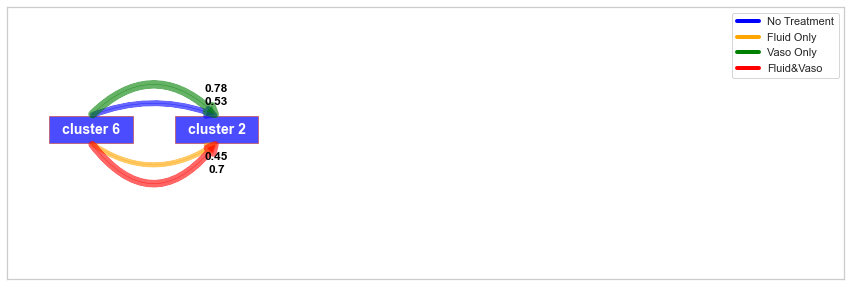

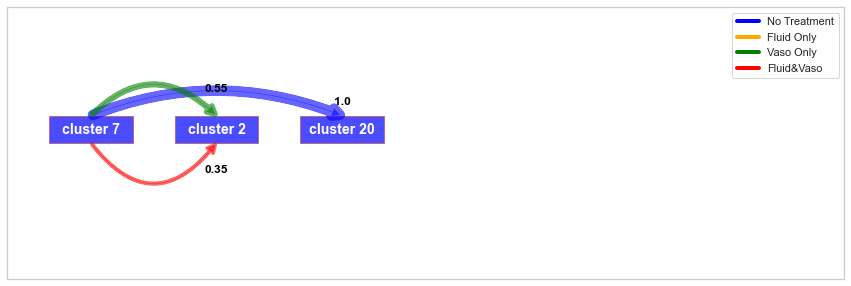

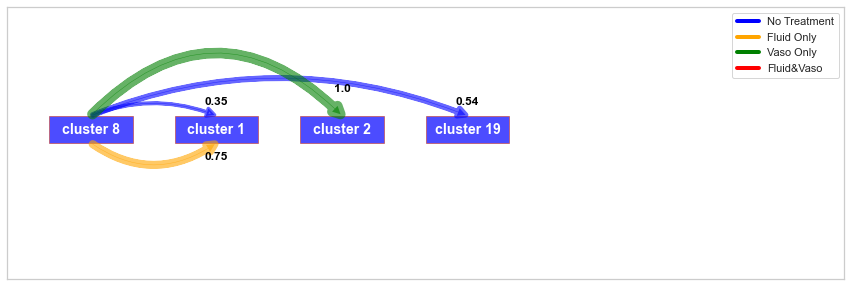

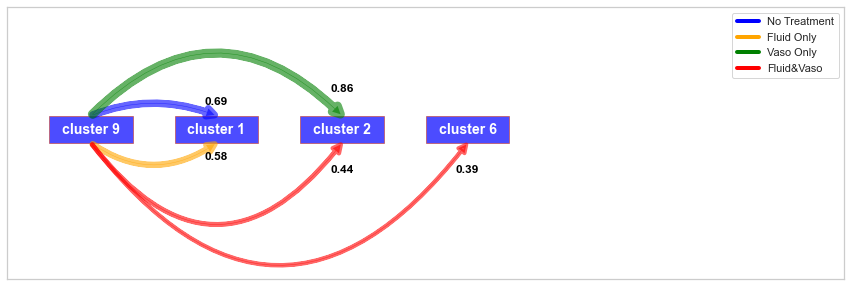

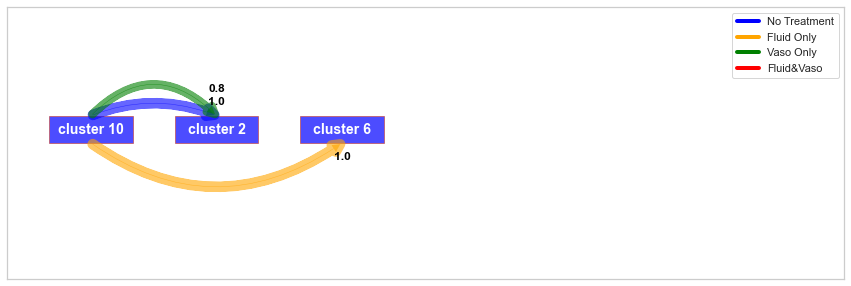

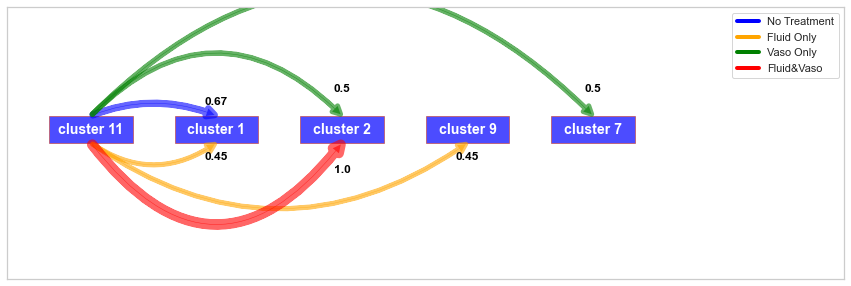

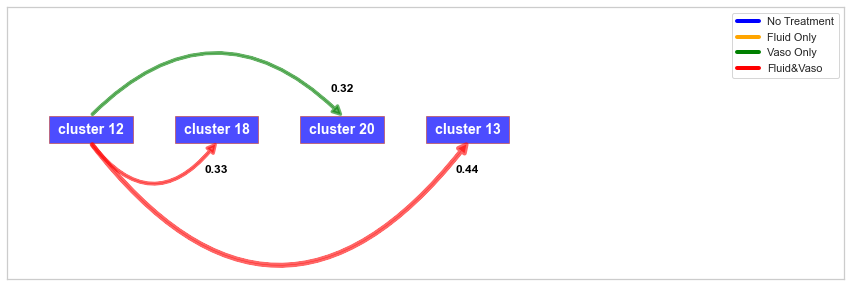

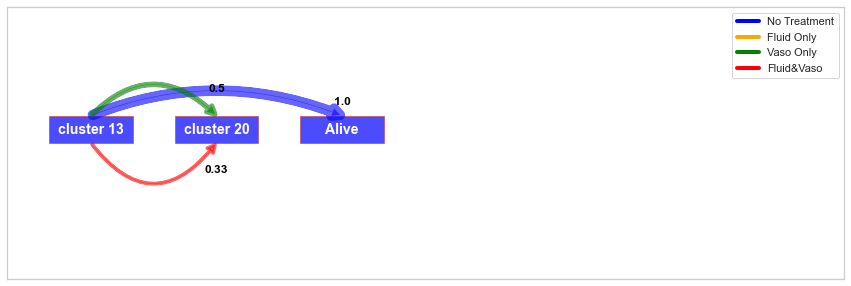

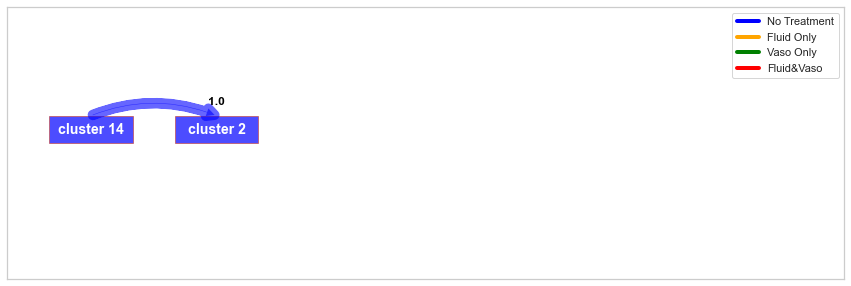

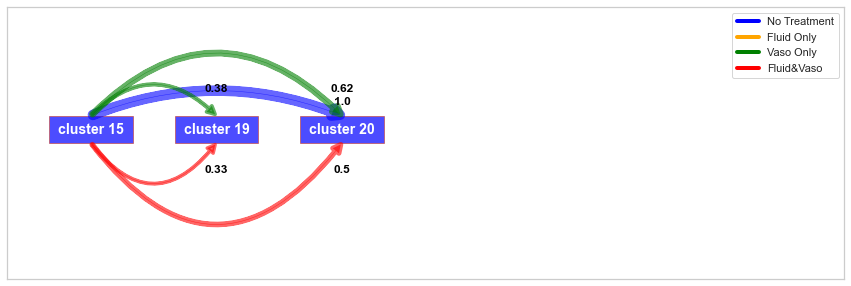

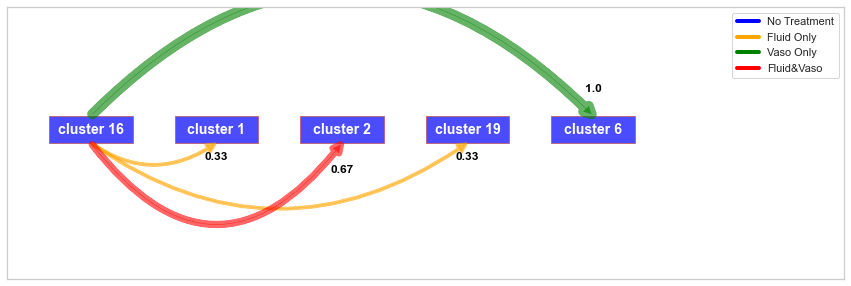

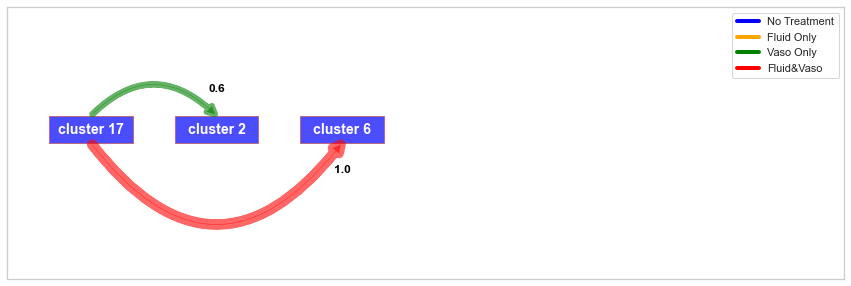

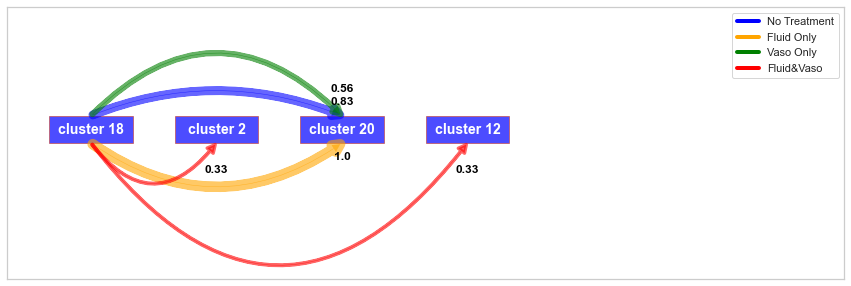

<IPython.core.display.Javascript object>

In [70]:
draw_tiles(tmat_large_only, "../results/visualization/", vis_thresh=0.3)

#### Save TSA_norm, TSA and Mortality with small clusters excluded. Save MAP and Urine for each cluster. Choose either "Visualization Clusters Only" or "Include Clusters Only"

Visualization Clusters Only

In [67]:
# Include last two mortality state
tmat_include_clusters = np.append(viz_include_clusters, [-2, -1])

# create mapping from cluster to new states
cluster_to_state = {
    x: y for x, y in zip(viz_include_clusters, range(len(viz_include_clusters)))
}

tmat_large_only_viz = tmat[tmat_include_clusters, :, :]
tmat_large_only_viz = tmat_large_only_viz[:, :, tmat_include_clusters]
tmat_large_only = tmat[tmat_include_clusters, :, :]
mortchance_last_large_only = mortchance_last[viz_include_clusters, :]
TSA_normalized_large_only = TSA_normalized[viz_include_clusters, :]
TSA_large_only = TSA[viz_include_clusters, :]

# #Load from saved numpy files
# TSA_normalized_large_only = np.load("tsa_norm_hierarchical_large_only.npy")
# mortchance_last_large_only = np.load("mortprobs_hierarchical_large_only.npy")

# np.save("tmat_hierarchical_ml4h_kernel_for_viz.npy", tmat_large_only_viz)
# np.save("tmat_hierarchical_ml4h_kernel.npy", tmat_large_only)
# np.save("mortprobs_hierarchical_ml4h_kernel.npy", mortchance_last_large_only)
# np.save("tsa_norm_hierarchical_ml4h_kernel.npy", TSA_normalized_large_only)
# np.save("tsa_hierarchical_ml4h_kernel.npy", TSA_large_only)

map_index = 0
urine_index = 6
maps = np.array([s.mean(axis=0)[map_index] for s in S1_viz_by_label])
urines = np.array([s.mean(axis=0)[urine_index] for s in S1_viz_by_label])

maps_large_only = maps[viz_include_clusters]
urines_large_only = urines[viz_include_clusters]

# np.save("maps_hierarchical_ml4h_kernel.npy", maps_large_only)
# np.save("urines_hierarchical_ml4h_kernel.npy", urines_large_only)

<IPython.core.display.Javascript object>

Include Cluster Only

In [68]:
# Include last two mortality state
tmat_include_clusters = np.append(included_clusters, [-2, -1])

# create mapping from cluster to new states
cluster_to_state = {
    x: y for x, y in zip(included_clusters, range(len(included_clusters)))
}

tmat_large_only = tmat[tmat_include_clusters, :, :]
tmat_large_only = tmat_large_only[:, :, tmat_include_clusters]
mortchance_last_large_only = mortchance_last[included_clusters, :]
TSA_normalized_large_only = TSA_normalized[included_clusters, :]
TSA_large_only = TSA[included_clusters, :]

# Save matrix
np.save(f"../results/intermediate/tmat_hierarchical_large_only_{version_date}.npy", tmat_large_only)
np.save(
    f"../results/intermediate/mortprobs_hierarchical_large_only_{version_date}.npy", mortchance_last_large_only
)
np.save(
    f"../results/intermediate/tsa_norm_hierarchical_large_only_{version_date}.npy", TSA_normalized_large_only
)
np.save(f"../results/intermediate/tsa_hierarchical_large_only_{version_date}.npy", TSA_large_only)

maps = np.array([s.mean(axis=0)[map_index] for s in S1_viz_by_label])
urines = np.array([s.mean(axis=0)[urine_index] for s in S1_viz_by_label])

maps_large_only = maps[included_clusters]
urines_large_only = urines[included_clusters]

# Save maps and urine
np.save(f"../results/intermediate/maps_hierarchical_large_only_{version_date}.npy", maps_large_only)
np.save(f"../results/intermediate/urines_hierarchical_large_only_{version_date}.npy", urines_large_only)

<IPython.core.display.Javascript object>

## Modeling and Evaluation

Run through `04.policy_derivation` notebook to get evaluation policies, then continue running through remainder of the notebook.

#### OPE

In [71]:
def lin_reward_func(bps, cutoffs=[60, 75, 80, 85], vals=[-1, -0.15, -0.05, 0]):
    """Calculate reward based on blood pressure level"""
    return np.interp(bps, cutoffs, vals)


def convert_compressed_traj(
    compressed_trajs, patient_mortality, maps, included_clusters
):
    """Combine states in same decision region and compress trajectories"""
    cur_states_cluster, actions, rewards = [], [], []

    for pid, (cvec, avec) in compressed_trajs.items():
        # exclude too small clusters
        mask = [1 if x in included_clusters else 0 for x in cvec]
        cvec = [cvec[i] for i in range(len(mask)) if mask[i] == 1]
        avec = [avec[i] for i in range(len(mask)) if mask[i] == 1]
        if len(cvec) > 0:
            cur_states_cluster.append(cvec)
            actions.append(avec)
            reward = list(lin_reward_func(maps[cvec[1:]]))
            if len(reward) > 0:
                reward.extend([-patient_mortality[pid]])
            else:
                reward = [-patient_mortality[pid]]
            rewards.append(reward)
    return cur_states_cluster, actions, rewards


def episode_return(R, discount=0.98):
    """
    Helper function to return the discounted sum of a list of rewards `R`.
    Return `R` if it is one step bandit.
    """
    if isinstance(R, float):
        return R
    return sum(r * discount ** t for t, r in enumerate(R))


def ESS(W):
    return np.sum(W) ** 2 / np.sum(W ** 2)


def IS_weights(eval_probs, behavior_probs):
    weights = np.array(
        [np.prod(ep) / np.prod(bp) for ep, bp in zip(eval_probs, behavior_probs)]
    )
    # weights clipping
    p95 = np.percentile(weights, 95)
    weights = np.array([p95 if w > p95 else w for w in weights])
    return weights


def WIS_weights(eval_probs, behavior_probs):
    weights = IS_weights(eval_probs, behavior_probs)
    mask = np.where(~np.isnan(weights))[0]
    # weights clipping
    weights = weights[mask] / np.sum(weights[mask])
    p95 = np.percentile(weights, 95)
    weights = np.array([p95 if w > p95 else w for w in weights])
    return weights, mask


def IS(eval_probs, behavior_probs, rewards):
    """Importance Sampling for OPE.
    Reference: Equation 3.7 of [Thomas 2015] (p37)"""
    weights = IS_weights(eval_probs, behavior_probs)
    mask = np.where(~np.isnan(weights))[0]
    ess = ESS(weights[mask])
    raw_return = np.array([episode_return(R) for R in rewards])
    estimated_return = np.dot(weights[mask], raw_return[mask])
    return estimated_return, ess


def WIS(eval_probs, behavior_probs, rewards):
    """Weighted Importance Sampling for OPE.
    Reference: Equation 3.21 of [Thomas 2015] (p53)"""
    weights, mask = WIS_weights(eval_probs, behavior_probs)
    ess = ESS(weights)
    raw_return = np.array([episode_return(R) for R in rewards])
    estimated_return = np.dot(weights, raw_return[mask])
    return estimated_return, ess


def get_eval_policy(filename, soft=0.05):
    eval_actions = np.load(filename)[:-2]
    k = eval_actions.shape[0]
    if soft > 0:
        eval_policy = np.zeros((k, 4)) + soft / 3
        eval_policy[range(k), eval_actions] = 1 - soft
    return eval_policy


def make_action_probs(states, actions, policy, cluster_to_state):
    output = []
    for s, a in zip(states, actions):
        s = [cluster_to_state[x] for x in s]
        output.append(policy[s, a])
    return output

<IPython.core.display.Javascript object>

In [72]:
eval_policy_piecewise = get_eval_policy(
    f"../results/model/piecewise_pi_{version_date}.npy"
)
eval_policy_mortprob = get_eval_policy(
    f"../results/model/mortprob_pi_{version_date}.npy"
)
eval_policy_terminal = get_eval_policy(
    f"../results/model/terminal_pi_{version_date}.npy"
)
behavior_policy = TSA_normalized_large_only

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


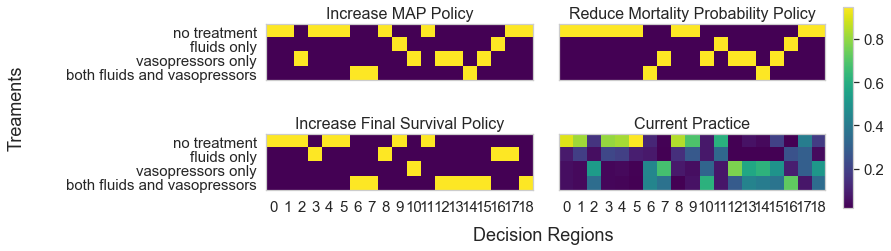

<IPython.core.display.Javascript object>

In [120]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
state_space = len(included_clusters)
action_space = 4

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 4))
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.15, top=0.85, wspace=0.1, hspace=0.2)
cmap = "viridis"
ax[0, 0].imshow(eval_policy_piecewise.T, cmap)
ax[0, 0].set_title("Increase MAP Policy", fontsize=16)
ax[0, 0].set_xticks(np.arange(state_space))
ax[0, 0].set_yticks(np.arange(action_space))
ax[0, 0].set_yticklabels(
    [
        "no treatment",
        "fluids only",
        "vasopressors only",
        "both fluids and vasopressors",
    ],
)
ax[0, 0].grid(False)
ax[0, 1].imshow(eval_policy_mortprob.T, cmap)
ax[0, 1].set_title("Reduce Mortality Probability Policy", fontsize=16)
ax[0, 1].set_xticks(np.arange(state_space))
ax[0, 1].set_yticks(np.arange(action_space))
ax[0, 1].grid(False)
im = ax[1, 0].imshow(eval_policy_terminal.T, cmap)
ax[1, 0].set_title("Increase Final Survival Policy", fontsize=16)
ax[1, 0].set_xticks(np.arange(state_space))
ax[1, 0].set_yticks(np.arange(action_space))
ax[1, 0].grid(False)
ax[1, 1].imshow(behavior_policy.T, cmap)
ax[1, 1].set_title("Current Practice", fontsize=16)
ax[1, 1].set_xticks(np.arange(state_space))
ax[1, 1].grid(False)

fig.text(0.42, 0.04, "Decision Regions", ha="center", fontsize=18)
fig.text(-0.2, 0.5, "Treaments", va="center", rotation="vertical", fontsize=18)

ax[1, 1].set_yticks(np.arange(4))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.046, pad=0.03)


# plt.tight_layout(pad=2, h_pad=1, w_pad=1)
plt.savefig(
    f"../results/visualization/policy_comparison_{version_date}.png",
    bbox_inches="tight",
)
plt.show()

#### Get test trajectories

In [85]:
test = True

unique_pids_test, patient_starts_test, patient_ends_test = find_patient_sequence(
    P_dp_test
)
(
    patient_clusters_test,
    patient_actions_test,
    patient_mortality_test,
) = identify_patients_condition(
    "YOUR/PATH/TO/DATA/pid_mortality",
    unique_pids_test,
    patient_starts_test,
    patient_ends_test,
    S1_labels_ordered_test,
    A_dp_test,
)

_, compressed_trajs_test = test_count_transitions(
    patient_clusters_test, patient_actions_test, patient_mortality_test, k, test=test
)

<IPython.core.display.Javascript object>

In [86]:
# Train set cluster
cur_states_cluster, actions, rewards = convert_compressed_traj(
    compressed_trajs, patient_mortality, maps, cluster_to_state
)


# Test set cluster
cur_states_cluster_test, actions_test, rewards_test = convert_compressed_traj(
    compressed_trajs_test, patient_mortality_test, maps, cluster_to_state
)

<IPython.core.display.Javascript object>

In [87]:
test_set = True

# Evaluate policy on test set
if test_set:
    eval_probs_piecewise = make_action_probs(
        cur_states_cluster_test, actions_test, eval_policy_piecewise, cluster_to_state
    )
    eval_probs_mortprob = make_action_probs(
        cur_states_cluster_test, actions_test, eval_policy_mortprob, cluster_to_state
    )
    eval_probs_terminal = make_action_probs(
        cur_states_cluster_test, actions_test, eval_policy_terminal, cluster_to_state
    )

    behavior_probs = make_action_probs(
        cur_states_cluster_test, actions_test, behavior_policy, cluster_to_state
    )
else:  # Evaluate policy on train set
    eval_probs_piecewise = make_action_probs(
        cur_states_cluster, actions, eval_policy_piecewise, cluster_to_state
    )
    eval_probs_mortprob = make_action_probs(
        cur_states_cluster, actions, eval_policy_mortprob, cluster_to_state
    )
    eval_probs_terminal = make_action_probs(
        cur_states_cluster, actions, eval_policy_terminal, cluster_to_state
    )

    behavior_probs = make_action_probs(
        cur_states_cluster, actions, behavior_policy, cluster_to_state
    )

<IPython.core.display.Javascript object>

In [217]:
if test_set:
    print("Behavior Test")
    print("IS: ", IS(behavior_probs, behavior_probs, rewards_test))
    print("WIS:", WIS(behavior_probs, behavior_probs, rewards_test))

    print("piecewise OPE Test")
    print("IS: ", IS(eval_probs_piecewise, behavior_probs, rewards_test))
    print("WIS: ", WIS(eval_probs_piecewise, behavior_probs, rewards_test))

    print("Mortprobs OPE Test")
    print("IS:", IS(eval_probs_mortprob, behavior_probs, rewards_test))
    print("WIS:", WIS(eval_probs_mortprob, behavior_probs, rewards_test))

    print("Terminal Probs OPE Test")
    print("IS: ", IS(eval_probs_terminal, behavior_probs, rewards_test))
    print("WIS: ", WIS(eval_probs_terminal, behavior_probs, rewards_test))

else:
    print("Behavior Train")
    print("IS: ", IS(behavior_probs, behavior_probs, rewards))
    print("WIS:", WIS(behavior_probs, behavior_probs, rewards))

    print("piecewise OPE Train")
    print("IS: ", IS(eval_probs_piecewise, behavior_probs, rewards))
    print("WIS: ", WIS(eval_probs_piecewise, behavior_probs, rewards))

    print("Mortprobs OPE Train")
    print("IS:", IS(eval_probs_mortprob, behavior_probs, rewards))
    print("WIS:", WIS(eval_probs_mortprob, behavior_probs, rewards))

    print("Terminal Probs OPE Train")
    print("IS: ", IS(eval_probs_terminal, behavior_probs, rewards))
    print("WIS: ", WIS(eval_probs_terminal, behavior_probs, rewards))

Behavior Test
IS:  (-1154.320401733386, 1689.0)
WIS: (-0.6834342224590797, 1689.0)
piecewise OPE Test
IS:  (-717.1935018152982, 1305.5612613558508)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


WIS:  (-0.4599142976038225, 1305.5612613558508)
Mortprobs OPE Test
IS: (-764.6546330394458, 1325.9617423316151)
WIS: (-0.4818542417825479, 1325.9617423316156)
Terminal Probs OPE Test
IS:  (-437.46044992435156, 1185.8586509420495)
WIS:  (-0.31665586696616516, 1185.8586509420488)


<IPython.core.display.Javascript object>

**Random Sample 5 folds to get average and std**

In [89]:
WIS_list = [[] for _ in range(4)]
ESS_list = [[] for _ in range(4)]
all_policy = [
    behavior_probs,
    eval_probs_piecewise,
    eval_probs_mortprob,
    eval_probs_terminal,
]

for i in range(5):
    sample_idx = np.random.choice(np.arange(len(behavior_probs)), 1000)
    rewards_subset = [rewards_test[int(i)] for i in sample_idx]
    behavior_subset = [behavior_probs[int(i)] for i in sample_idx]
    for j, policy in enumerate(all_policy):
        policy_subset = [policy[int(k)] for k in sample_idx]
        wis, ess = WIS(policy_subset, behavior_subset, rewards_subset)
        WIS_list[j].append(wis)
        ESS_list[j].append(ess)

for wis, ess, policy in zip(
    WIS_list, ESS_list, ["behavior", "piecewise", "mortality", "terminal"]
):
    print(f"for {policy}")
    print(f"Average WIS is {np.mean(wis)}")
    print(f"Std for WIS is {np.std(wis)}")
    print(f"Average ESS is {np.mean(ess)}")
    print(f"Std for ESS is {np.std(ess)}")

for behavior
Average WIS is -0.6723400616594095
Std for WIS is 0.04205779829117766
Average ESS is 999.6000000000004
Std for ESS is 0.48989794855685836
for piecewise
Average WIS is -0.4490193404917634
Std for WIS is 0.0328043035248486
Average ESS is 770.5024386178991
Std for ESS is 6.072227756693276
for mortality
Average WIS is -0.47543084694052967
Std for WIS is 0.031722355421277285
Average ESS is 785.3710657473426
Std for ESS is 8.611801625366997
for terminal
Average WIS is -0.3040867606539081
Std for WIS is 0.016488260131937875
Average ESS is 705.3435823633058
Std for ESS is 8.373788497695964


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>

#### Identify lactate change for behavior policy and evaluation policy

Steps:
1. Find state-action pairs whose next lactate level changes, what's the amount of change
2. Find which ones are recommeded actions and which ones are not recommended actions
3. Compare results

Train

In [441]:
dp_idx_to_orig = {i: j for i, j in enumerate(dp_idx)}
eval_policy = eval_policy_terminal
lactate_index = 4

lactate_change = []
behavior_probs = []
eval_probs = []

for i, pid in enumerate(unique_pids):
    clusters, actions = patient_clusters[pid], patient_actions[pid]
    actions = summarize_actions(np.array(actions))
    for count, (cluster, action) in enumerate(zip(clusters, actions)):
        orig_idx = dp_idx_to_orig[patient_starts[i] + count]
        orig_idx_next = orig_idx + 1
        # features belong to the same patient
        if (
            (orig_idx_next < len(PID_train))
            and (PID_train[orig_idx] == PID_train[orig_idx_next])
            and (
                S1_train_viz[orig_idx, lactate_index]
                != S1_train_viz[orig_idx_next, lactate_index]
            )
            and (cluster in included_clusters)
        ):
            lactate_change.append(
                S1_train_viz[orig_idx_next, lactate_index]
                - S1_train_viz[orig_idx, lactate_index]
            )
            eval_probs.append(np.array(eval_policy[cluster_to_state[cluster], action]))
            behavior_probs.append(
                np.array(behavior_policy[cluster_to_state[cluster], action])
            )

<IPython.core.display.Javascript object>

In [443]:
print(
    f"Lactate reduction rewards with behavior policy: {WIS(behavior_probs, behavior_probs, lactate_change)[0]}"
)
print(
    f"Lactate reduction rewards with evaluation policy: {WIS(eval_probs, behavior_probs, lactate_change)[0]}"
)

Lactate reduction rewards with behavior policy: -0.08334228909188608
Lactate reduction rewards with evaluation policy: 0.0014491190371750953


<IPython.core.display.Javascript object>

Test

In [445]:
dp_idx_to_orig_test = {i: j for i, j in enumerate(dp_idx_test)}

lactate_change_test = []
behavior_probs_test = []
eval_probs_test = []

for i, pid in enumerate(unique_pids_test):
    clusters, actions = patient_clusters_test[pid], patient_actions_test[pid]
    actions = summarize_actions(np.array(actions))
    for count, (cluster, action) in enumerate(zip(clusters, actions)):
        orig_idx = dp_idx_to_orig_test[patient_starts_test[i] + count]
        orig_idx_next = orig_idx + 1
        # features belong to the same patient
        if (
            (orig_idx_next < len(PID_test))
            and (PID_test[orig_idx] == PID_test[orig_idx_next])
            and (
                S1_test_viz[orig_idx, lactate_index]
                != S1_test_viz[orig_idx_next, lactate_index]
            )
            and (cluster in included_clusters)
        ):
            lactate_change_test.append(
                S1_test_viz[orig_idx_next, lactate_index]
                - S1_test_viz[orig_idx, lactate_index]
            )
            eval_probs_test.append(
                np.array(eval_policy[cluster_to_state[cluster], action])
            )
            behavior_probs_test.append(
                np.array(behavior_policy[cluster_to_state[cluster], action])
            )

print(
    f"Lactate reduction rewards with behavior policy: {WIS(behavior_probs_test, behavior_probs_test, lactate_change_test)[0]}"
)
print(
    f"Lactate reduction rewards with evaluation policy: {WIS(eval_probs_test, behavior_probs_test, lactate_change)[0]}"
)

Lactate reduction rewards with behavior policy: -0.06072234762979681
Lactate reduction rewards with evaluation policy: -0.08540905370469924


<IPython.core.display.Javascript object>

## Post analysis

1. For all patients at original timescale, identify expected mortality based on clinician's actions
2. For all patients at original timescale, identify recommneded actions
3. For all patients at original timescale, identify expected mortality based on recommended actions
3. compare mortality for clinician action and recommended actions, find three patients

- patient1: recommended action is no action but clincian took action. Expected mortality from recommended action should be lower than clician's action.
- patient 2: recommended action is different from clinician action and expected mortality is lower than clinician's action
- patient 3: expected mortality is close to 1 for both recommended and clician's actions

expected output from this exercise:
1. patient id
2. time range
3. expected mortality for clician actions (ideally for the time range, clician's action is the same. If there are multiple timeframes, pick one where clician's actions are the same)
4. expected mortality for recommended actions
5. clician actions
6. recommended actions

In [210]:
action_by_cluster_mortality_eval_policy = {
    k: v for k, v in zip(included_clusters, np.argmax(eval_policy_mortprob, axis=1))
}
action_differ_records = {}
counter = 0
time_idx = 8
for pid in list(patient_actions.keys())[:300]:
    pid_cluster = patient_clusters[pid]
    pid_action = summarize_actions(patient_actions[pid])
    pid_dp_len = len(pid_cluster)
    pid_state = S1_viz_dp[counter : counter + pid_dp_len]
    for i, (c, a) in enumerate(zip(pid_cluster, pid_action)):
        # Find large clusters and actions where recommended actions differ from real actions
        if (c in action_by_cluster_mortality_eval_policy) and (
            action_by_cluster_mortality_eval_policy[c] != a
        ):
            action_differ_records[pid] = {
                "timestep": pid_state[i][time_idx],
                "recommended action": action_by_cluster_mortality_eval_policy[c],
                "actual action": a,
            }
            counter += pid_dp_len
            break

<IPython.core.display.Javascript object>

In [216]:
# len(action_differ_records.keys())
pid_examine_df = pd.DataFrame(action_differ_records).T
pid_examine_df.reset_index(inplace=True)
pid_examine_df.columns = [
    "patient_id",
    "timestep",
    "recommended action",
    "actual action",
]
action_dict = {
    0: "no fluid, no vaso",
    1: "fluid only",
    2: "vaso only",
    3: "both fluid and vaso",
}

for index, row in pid_examine_df.iterrows():
    pid_examine_df.loc[index, "recommended action"] = action_dict[
        row["recommended action"]
    ]
    pid_examine_df.loc[index, "actual action"] = action_dict[row["actual action"]]

pid_examine_recommend_no_action_df = pid_examine_df[
    pid_examine_df["recommended action"] == "no fluid, no vaso"
]
pid_examine_recommend_action_df = pid_examine_df[
    pid_examine_df["recommended action"] != "no fluid, no vaso"
]

print(len(pid_examine_recommend_action_df), len(pid_examine_recommend_no_action_df))

12 124


<IPython.core.display.Javascript object>

In [277]:
pid_examine_output_df = pd.concat(
    (pid_examine_recommend_action_df, pid_examine_recommend_no_action_df[:38])
).reset_index(drop=True)
pid_examine_output_df.to_csv(
    "../results/evaluation/patients_actions_examine_01312022.csv", index=False
)
pid_examine_output_df.head()

patient_id  timestep   recommended action        actual action
0      236923       4.0  both fluid and vaso            vaso only
1      234228      28.0  both fluid and vaso           fluid only
2      239472       1.0  both fluid and vaso    no fluid, no vaso
3      244224      12.0            vaso only  both fluid and vaso
4      229013       4.0  both fluid and vaso    no fluid, no vaso

<IPython.core.display.Javascript object>

In [227]:
##################################################################
## Identify recommended actions for patients in clusters #########
mortchance_last = mortpos_last / (mortpos_last + mortneg_last)
mortchance_last = mortchance_last[included_clusters]

patients_mortchance_clinician = dict()
patients_mortchance_recommendation = dict()
patients_recommended_actions = dict()
patients_clinician_actions = dict()
included_clusters_set = set(included_clusters)

for pid in list(patient_clusters.keys())[:2000]:
    trajectory = patient_clusters[pid]
    clinician_actions = summarize_actions(patient_actions[pid])
    if set(trajectory).issubset(included_clusters_set):
        patient_mortchance_clinician_pid = [
            mortchance_last[cluster_to_state[cluster], action]
            for cluster, action in zip(trajectory, clinician_actions)
        ]
        patient_recommended_actions_pid = [
            np.argmax(eval_policy_terminal[cluster_to_state[cluster]])
            for cluster in trajectory
        ]
        patient_mortchance_recommended_pid = [
            mortchance_last[cluster_to_state[cluster], action]
            for cluster, action in zip(trajectory, patient_recommended_actions_pid)
        ]

        patients_mortchance_clinician[pid] = patient_mortchance_clinician_pid
        patients_mortchance_recommendation[pid] = patient_mortchance_recommended_pid
        patients_recommended_actions[pid] = patient_recommended_actions_pid
        patients_clinician_actions[pid] = clinician_actions
##################################################################

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

In [244]:
# Function to convert back to original timeframe
def convert_to_original_timeframe(pid, dp_step):
    pid_first_occurance = np.where(PID_train == pid)[0][0]
    pid_first_occurance_dp = np.where(P_dp == pid)[0][0]
    print(pid_first_occurance, pid_first_occurance_dp)
    return dp_idx[pid_first_occurance_dp + dp_step] - pid_first_occurance

<IPython.core.display.Javascript object>

Find patient 1 - recommended action is no action but clincian took action. Expected mortality from recommended action should be lower than clician's action.

In [268]:
for pid in [205286]:
    # for pid in list(patients_mortchance_clinician.keys())[10:20]:
    recommended_actions = patients_recommended_actions[pid]
    clinician_actions = list(patients_clinician_actions[pid])
    if recommended_actions != clinician_actions:
        print(pid)
        print(len(recommended_actions))
        for i, (recommended, clinician) in enumerate(
            zip(recommended_actions, clinician_actions)
        ):
            if (
                recommended != clinician
                and recommended == 0
                and patients_mortchance_recommendation[pid][i]
                < patients_mortchance_clinician[pid][i]
            ):
                print(i)
                print(recommended, clinician)
                print(
                    patients_mortchance_recommendation[pid][i],
                    patients_mortchance_clinician[pid][i],
                )
                print(patient_mortality[pid])
                break
        break

205286
2
0
0 1
0.16184971098265896 0.21333333333333335
0


<IPython.core.display.Javascript object>

Find patient 2 - recommended action is different from clinician action and expected mortality is lower than clinician's action

In [272]:
for pid in [236923]:
    recommended_actions = patients_recommended_actions[pid]
    clinician_actions = list(patients_clinician_actions[pid])
    if recommended_actions != clinician_actions:
        print(pid)
        print(len(recommended_actions))
        for i, (recommended, clinician) in enumerate(
            zip(recommended_actions, clinician_actions)
        ):
            if (
                recommended != clinician
                and recommended != 0
                and patients_mortchance_recommendation[pid][i]
                < patients_mortchance_clinician[pid][i]
            ):
                print(i)
                print(recommended, clinician)
                print(
                    patients_mortchance_recommendation[pid][i],
                    patients_mortchance_clinician[pid][i],
                )
                print(patient_mortality[pid])
                break
        # break

236923
10
0
3 2
0.07909604519774012 0.19680851063829788
0


<IPython.core.display.Javascript object>

Find patient 3 - expected mortality is close to 1 for both recommended and clician's actions

In [ ]:
for pid in patients_mortchance_clinician.keys():
    #     print(patients_mortchance_clinician[pid])
    #     print(patients_mortchance_recommendation[pid])
    #     print(patients_clinician_actions[pid])
    #     print(patients_recommended_actions[pid])

    patient_cluster = patient_clusters[pid]
    for cluster in patient_cluster
        recommended_actions = patients_recommended_actions[pid]
        clinician_actions = list(patients_clinician_actions[pid])
        if recommended_actions != clinician_actions:
            print(pid)
            print(len(recommended_actions))
            for i, (recommended, clinician) in enumerate(
                zip(recommended_actions, clinician_actions)
            ):
                if (
                    recommended != clinician
                    and recommended != 0
                    and patients_mortchance_recommendation[pid][i]
                    < patients_mortchance_clinician[pid][i]
                ):
                    print(i)
                    print(recommended, clinician)
                    print(
                        patients_mortchance_recommendation[pid][i],
                        patients_mortchance_clinician[pid][i],
                    )
                    break

|Scenario| Patient ID | Hour since admission | Expected Mortality Clinician Actions |Expected Mortality Recommended Actions | Clinician Action | Recommended Action | Final Outcome|
| --- | --- | --- | --- | --- | --- |--- |--- |
| Patient type 1- recommended action is no action but clincian took action. Expected mortality from recommended action should be lower than clician's action.| 205286 | 9 | 0.21|0.16 | 1| 0| Patient Alive|
| Patient type 2- recommended action is different from clinician action and expected mortality is lower than clinician's action.| 236923 | 4 | 0.20|0.08 | 2| 3| Patient Alive |
| Patient type 2- expected mortality is high for both recommended and clician's actions.| 244224 | 12 | 0.88|0.71 | 3| 2| Patient Dead|